# 抖音电商平台召回礼券优化策略

## 1、业务背景

抖音商城将近 30 天未在商城提交下单过订单的用户浏览商城视为用户回归，当用户回归时，平台会发放平台召回礼券，召回礼券的有效期是12小时。  
回归礼券在用户30天未在商城提交下单过订单后，首次浏览商城时弹窗显示，弹窗显示召回礼券的金额、有效期时间倒计时，弹窗下方有“领取”的按钮，弹窗右上方有较小的关闭窗口按钮，弹窗显示后即自动领券，无论用户是否点击“领取”按钮，优惠券都自动到账。

## 2、基础数据

User_id：用户ID  
Coupon_time：领取回归礼券的时间段（ 0-6点 / 7-12点 / 13-18点 / 19-24点）  
   
（以下为领取召回券前的行为数据）  
Buy_gap_days：领取召回券与前一次下单间隔天数  
Browse_gap_days：领取召回券与前一次浏览商城间隔天数  
Browse_duration：浏览商城时长（分钟）  
Browse_product：浏览商品数量  
Cart_product：加购商品数    
Livestream_duration：观看商城直播时长  
Search_count：商城搜索次数  
Order_num：订单数  
Order_amount：订单金额  
Coupon_order：使用优惠券的订单数  
 
Is_repurchase：是否使用召回礼券  

## 3、整理数据

### 读取数据

导入数据分析所需要的库，并通过Pandas的`read_csv`函数，将原始数据文件`recall_coupon_data`里的数据内容，解析为DataFrame并赋值给变量`original_data`。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
original_data = pd.read_csv('recall_coupon_data.csv')
original_data

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase
0,58720256,1,1,25,6,21,6,12,2,31,19,19-24点,0
1,94371845,6,6,147,55,111,0,30,18,33,10,13-18点,0
2,27262983,3,2,85,23,47,0,36,6,35,25,7-12点,0
3,75497485,2,2,44,16,70,4,26,5,33,21,0-6点,0
4,33554447,1,1,9,3,6,0,0,0,31,19,19-24点,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,81788906,2,1,31,22,44,2,22,4,321,17,19-24点,0
799996,12582899,1,1,17,9,18,8,4,3,373,13,0-6点,0
799997,20971508,7,7,91,43,87,18,0,14,382,210,13-18点,0
799998,56623094,3,2,90,13,53,12,33,4,355,133,19-24点,0


### 评估和清理数据

在这一部分中，我们将对在上一部分建立的`original_data`DataFrame所包含的数据进行评估和清理。
主要从两个方面进行：结构和内容，即整齐度和干净度。
数据的结构性问题指不符合“每个变量为一列，每个观察值为一行，每种类型的观察单位为一个表格”这三个标准；数据的内容性问题包括存在丢失数据、重复数据、无效数据等。

为了区分开经过清理的数据和原始的数据，我们创建新的变量cleaned_data，让它为original_data复制出的副本。我们之后的清理步骤都将被运用在cleaned_data上。

In [3]:
cleaned_data = original_data.copy()

### 数据整齐度

In [4]:
cleaned_data.head(10)

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase
0,58720256,1,1,25,6,21,6,12,2,31,19,19-24点,0
1,94371845,6,6,147,55,111,0,30,18,33,10,13-18点,0
2,27262983,3,2,85,23,47,0,36,6,35,25,7-12点,0
3,75497485,2,2,44,16,70,4,26,5,33,21,0-6点,0
4,33554447,1,1,9,3,6,0,0,0,31,19,19-24点,0
5,10485776,1,1,9,8,24,0,13,1,31,12,19-24点,0
6,81788947,1,1,22,8,36,6,6,1,33,20,19-24点,0
7,83886105,4,4,87,8,22,4,0,3,35,25,19-24点,0
8,94371868,2,2,26,23,47,20,0,5,31,9,13-18点,0
9,69206047,3,2,37,13,27,5,36,3,31,7,19-24点,0


从头部的10行数据来看，数据符合“每个变量为一列，每个观察值为一行，每种类型的观察单位为一个表格”，因此不存在结构性问题。

### 数据干净度

接下来通过info，对数据内容进行大致了解。

In [5]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_id              800000 non-null  int64 
 1   Order_num            800000 non-null  int64 
 2   Coupon_order         800000 non-null  int64 
 3   Order_amount         800000 non-null  int64 
 4   Browse_product       800000 non-null  int64 
 5   Browse_duration      800000 non-null  int64 
 6   Cart_product         800000 non-null  int64 
 7   Livestream_duration  800000 non-null  int64 
 8   Search_count         800000 non-null  int64 
 9   Buy_gap_days         800000 non-null  int64 
 10  Browse_gap_days      800000 non-null  int64 
 11  Coupon_time          800000 non-null  object
 12  Is_repurchase        800000 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 79.3+ MB


从输出结果来看，cleaned_data数据共有800000条观察值，不存在缺失值。  
User_id表示样本ID，数据类型不应为数字，应为字符串，所以需要进行数据格式转换。  
Coupon_time为分类数据，应该转换为category数据类型，节约内存空间。

In [6]:
cleaned_data['User_id'] = cleaned_data['User_id'].astype(str)
cleaned_data['Coupon_time'] = cleaned_data['Coupon_time'].astype('category')

In [7]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   User_id              800000 non-null  object  
 1   Order_num            800000 non-null  int64   
 2   Coupon_order         800000 non-null  int64   
 3   Order_amount         800000 non-null  int64   
 4   Browse_product       800000 non-null  int64   
 5   Browse_duration      800000 non-null  int64   
 6   Cart_product         800000 non-null  int64   
 7   Livestream_duration  800000 non-null  int64   
 8   Search_count         800000 non-null  int64   
 9   Buy_gap_days         800000 non-null  int64   
 10  Browse_gap_days      800000 non-null  int64   
 11  Coupon_time          800000 non-null  category
 12  Is_repurchase        800000 non-null  int64   
dtypes: category(1), int64(11), object(1)
memory usage: 74.0+ MB


#### 处理缺失数据

从info方法的输出结果来看，cleaned_data不存在缺失值，因此不需要对缺失数据进行处理。

#### 处理重复数据

根据数据变量的含义以及内容来看，cleaned_data里的Userid是样本的唯一标识符，不应该存在重复，因此查看是否存在重复值。

In [8]:
cleaned_data['User_id'].duplicated().sum()

0

输出结果为0，说明不存在重复值。

#### 处理不一致数据

不一致数据可能存在于Coupon_time这一个变量中，我们要查看是否存在多个不同值指代同一种类的情况。

In [9]:
cleaned_data['Coupon_time'].value_counts()

Coupon_time
19-24点    271617
13-18点    240534
7-12点     192169
0-6点       95680
Name: count, dtype: int64

从以上输出结果来看，Coupon_time只有四种类型的值（19-24点、13-18点、7-12点、0-6点），不存在不一致数据。

#### 处理无效或错误数据

可以通过DataFrame的describe方法，对数值统计信息进行快速了解。

In [10]:
cleaned_data.describe()

,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Is_repurchase
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,2.473918,2.293430,44.002464,20.623316,61.385456,9.726586,13.936439,3.509570,88.242842,34.160166,0.033121
std,1.798792,1.742315,37.435210,18.297740,51.221611,10.149103,17.769740,4.231307,49.420395,26.640210,0.178953
min,1.000000,1.000000,5.000000,1.000000,3.000000,0.000000,0.000000,0.000000,31.000000,1.000000,0.000000
25%,1.000000,1.000000,18.000000,8.000000,21.000000,3.000000,0.750000,0.000000,50.000000,16.000000,0.000000
50%,2.000000,2.000000,30.000000,14.000000,42.000000,6.000000,8.000000,2.000000,75.000000,27.000000,0.000000
75%,3.000000,3.000000,57.000000,27.000000,91.000000,13.000000,20.000000,5.000000,114.000000,45.000000,0.000000
max,10.000000,10.000000,351.000000,155.000000,238.000000,53.000000,140.000000,50.000000,382.000000,342.000000,1.000000


从以上统计信息来看，cleaned_data里不存在脱离现实意义的数值。

## 问题1：召回礼券的使用率需要提升，数据分析师需分析现有数据，找寻提升点。（暂不考虑调整召回礼券的金额）

### 总体对比数据

总体观测不同Coupon_time（领取回归礼券的时间段）的Is_repurchase（是否使用召回礼券)的数量差异和使用召回礼券率，画条形图、饼图查看这四个领取时间段是否存在更优表现的时间段。

In [11]:
Is_repurchase_based_on_Coupon_time = cleaned_data.groupby('Coupon_time').agg(repurchase_amount=('Is_repurchase','sum'),total_amount=('Is_repurchase','count')).reset_index()
Is_repurchase_based_on_Coupon_time['turnover_rate'] = Is_repurchase_based_on_Coupon_time['repurchase_amount'] / Is_repurchase_based_on_Coupon_time['total_amount']
Is_repurchase_based_on_Coupon_time

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\3225566593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Is_repurchase_based_on_Coupon_time = cleaned_data.groupby('Coupon_time').agg(repurchase_amount=('Is_repurchase','sum'),total_amount=('Is_repurchase','count')).reset_index()


,Coupon_time,repurchase_amount,total_amount,turnover_rate
0,0-6点,3061,95680,0.031992
1,13-18点,8418,240534,0.034997
2,19-24点,9234,271617,0.033996
3,7-12点,5784,192169,0.030099


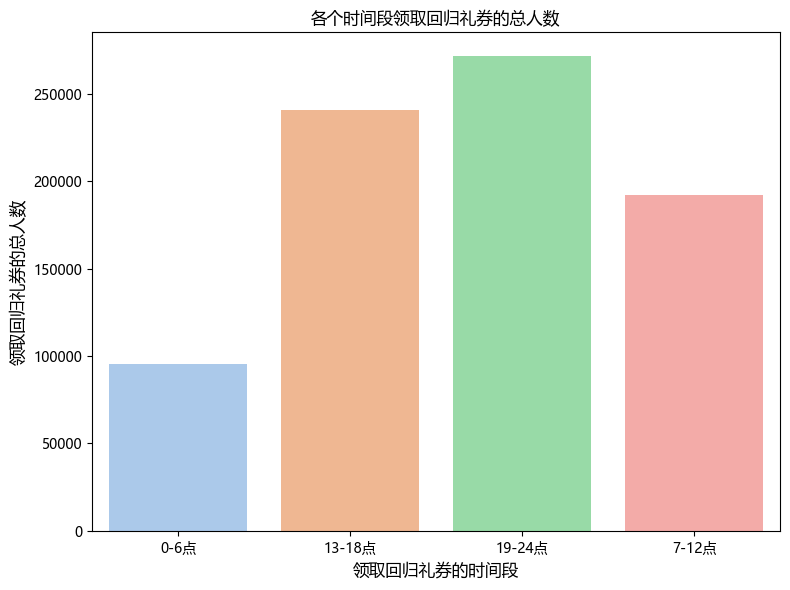

In [12]:
#设置图表色盘位“pastel”
sns.set_palette('pastel')
#设置出图宽高比
plt.figure(figsize=(8,6))
#画柱状图
sns.barplot(data=Is_repurchase_based_on_Coupon_time,x='Coupon_time',y='total_amount',hue='Coupon_time')
#添加标题和标签
plt.title("各个时间段领取回归礼券的总人数")
plt.xlabel("领取回归礼券的时间段",fontsize=12)
plt.ylabel("领取回归礼券的总人数",fontsize=12)
#设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']   
#显示图表
plt.tight_layout()
plt.show()

从各时间段的领取回归礼券的总人数来观测，0-6点这个时间段领取回归礼券的人数最少，推测是因为该时间段大部分抖音用户正在休息，19-24点这个时间段为领取回归礼券的人数最多，推测是因为该时间段大部分抖音用户下班了有时间上线。

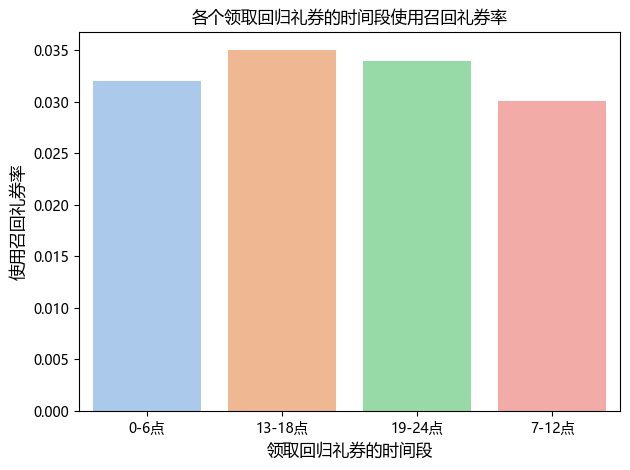

In [13]:
#画柱状图
sns.barplot(data=Is_repurchase_based_on_Coupon_time,x='Coupon_time',y='turnover_rate',hue='Coupon_time')
#添加标题和标签
plt.title("各个领取回归礼券的时间段使用召回礼券率")
plt.xlabel("领取回归礼券的时间段",fontsize=12)
plt.ylabel("使用召回礼券率",fontsize=12)
#显示图表
plt.tight_layout()
plt.show()

从各个领取回归礼券的时间段使用召回礼券率来观测，7-12点这个时间段使用召回礼券率最低为3.0%，13-18点这个时间段使用召回礼券率最高为3.5%，但是总体观测上图，各个时间段的使用召回礼券率差异不大，所以需要做使用率差异的显著性检验。

### 假设检验

我们将利用假设检验，检验四个领取回归礼券的时间段（0-6点、13-18点、19-24点、7-12点）在使用召回礼券率方面是否存在统计显著性差异。
我们采用卡方独立性检验，先引入卡方独立性检验所需要的模块。

In [14]:
from scipy.stats import chi2_contingency

In [15]:
# 构建列联表：行是领取回归礼券的时间段，列是是否使用召回礼券率（0或1）
contingency_table = pd.crosstab(cleaned_data['Coupon_time'],cleaned_data['Is_repurchase'])
# 检查列联表的形状，确保有足够的数据进行检验
if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
    print (f'数据不足，无法进行卡方检验。')
# 执行卡方检验
chi2,p,dof,expected = chi2_contingency(contingency_table)
#输出结果
print ('列联表：')
print (contingency_table)
print (f'卡方统计量：{chi2:.4f},自由度：{dof},p值：{p:.4f}')
print('期望频数：')
print(expected)
alpha = 0.05
if p < alpha:
    print("结论：拒绝原假设，四个领取回归礼券的时间段在使用召回礼券率存在显著差异(p<0,05)")
else:
    print("结论：接受原假设，四个领取回归礼券的时间段在使用召回礼券率不存在显著差异(p>0,05)")

列联表：
Is_repurchase       0     1
Coupon_time                
0-6点            92619  3061
13-18点         232116  8418
19-24点         262383  9234
7-12点          186385  5784
卡方统计量：91.5648,自由度：3,p值：0.0000
期望频数：
[[ 92510.9588       3169.0412    ]
 [232567.2132525    7966.7867475 ]
 [262620.70543875   8996.29456125]
 [185804.12250875   6364.87749125]]
结论：拒绝原假设，四个领取回归礼券的时间段在使用召回礼券率存在显著差异(p<0,05)


根据以上卡方检验后的数据得出结论：四个领取回归礼券的时间段的使用召回礼券率存在显著差异。因为是否使用召回礼券 = 领取召回礼券的总人数 x 使用率，所以结合召回礼券各时间段领取的总人数和召回礼券各时间段使用率情况，13-18点和19-24点这两个时间表现最好，所以可以推出一些专属时间段的营销活动（如打工人专场、夜猫子专场）等来进一步的扩大这两个时间段的领取召回券人群。从转化率上观察发现7-12点这个时间段使用召回礼券率最低，所以我们可以考虑缩短优惠券有效期，优化优惠券弹窗显示的内容或多次弹窗提醒等...具体调整方案由运营同事决定。

### 根据建立分类模型探索数据

根据此项目的所有数据特征列建立分类模型，当分类模型的性能较好时，模型系数可以揭示哪些行为或特征可以显著提升领取后的转化率。再利用决策树将特征进行分层，根据特征分层规则将用户分为诺干类，观测各类用户的使用召回礼券率。根据特征划分规则，调整发券策略。使得更多人群满足高使用率特征，从而总体提高使用召回礼券率。

#### 数据加载与预处理

In [16]:
# 将类别变量进行独热编码
cleaned_data_1 = pd.get_dummies(cleaned_data,columns=['Coupon_time'],dtype = int,drop_first = True)
cleaned_data_1

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Is_repurchase,Coupon_time_13-18点,Coupon_time_19-24点,Coupon_time_7-12点
0,58720256,1,1,25,6,21,6,12,2,31,19,0,0,1,0
1,94371845,6,6,147,55,111,0,30,18,33,10,0,1,0,0
2,27262983,3,2,85,23,47,0,36,6,35,25,0,0,0,1
3,75497485,2,2,44,16,70,4,26,5,33,21,0,0,0,0
4,33554447,1,1,9,3,6,0,0,0,31,19,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,81788906,2,1,31,22,44,2,22,4,321,17,0,0,1,0
799996,12582899,1,1,17,9,18,8,4,3,373,13,0,0,0,0
799997,20971508,7,7,91,43,87,18,0,14,382,210,0,1,0,0
799998,56623094,3,2,90,13,53,12,33,4,355,133,0,0,1,0


In [17]:
#cleaned_data_1 用于逻辑回归模型，cleaned_data_2用于随机森林、XGBoost模型
cleaned_data_2 = cleaned_data_1.copy()

In [18]:
#统计Is_repurchase的总体使用情况
cleaned_data_1_is_repurchase = cleaned_data_1['Is_repurchase'].value_counts().reset_index(name='amount')
cleaned_data_1_is_repurchase

,Is_repurchase,amount
0,0,773503
1,1,26497


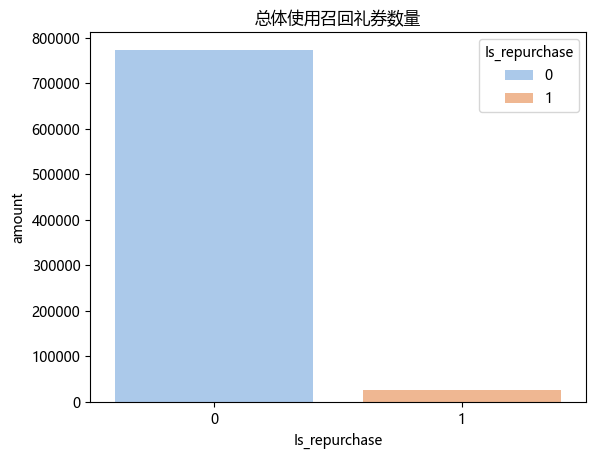

In [19]:
# 画柱状图可视化数据
sns.barplot(data = cleaned_data_1_is_repurchase,x='Is_repurchase',y='amount',hue = 'Is_repurchase')
plt.title('总体使用召回礼券数量')
plt.show()

差值比例在1：29到1：30之间，比例差距非常大，需要考虑可以下采样或者过采样方法，观察模型效果。

在本数据集中可以发现数值跨度较大，逻辑回归模型对特征尺度敏感，需要进行标准化归一化，可以使用StandardScaler把变量缩放到均值为0，标准差为1。

In [20]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [21]:
# 选取出数据集中的数值变量，将User_id,还有0/1的dummy变量剔除
num_cols = ['Order_num','Coupon_order','Order_amount','Browse_product','Browse_duration','Cart_product','Livestream_duration','Search_count','Buy_gap_days','Browse_gap_days']
# 创建 StandardScaler 对象
scaler = StandardScaler()
# 1）fit：计算数据集的均值和标准差
# 2）transform：对数据集进行标准化
cleaned_data_1_scaled_array = scaler.fit_transform(cleaned_data_1[num_cols])
# 保留原来的列名与索引
cleaned_data_1_scaled = pd.DataFrame(cleaned_data_1_scaled_array,index=cleaned_data_1.index,columns=num_cols)
# 将非数值列保留下来
other_df = cleaned_data_1.drop(columns=num_cols)
# 合并回完整DataFrame（按列拼接）
final_cleaned_data_1_scaled = pd.concat([cleaned_data_1_scaled,other_df],axis=1)
final_cleaned_data_1_scaled

,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,User_id,Is_repurchase,Coupon_time_13-18点,Coupon_time_19-24点,Coupon_time_7-12点
0,-0.819393,-0.742363,-0.507610,-0.799188,-0.788446,-0.367184,-0.108974,-0.356762,-1.158285,-0.569071,58720256,0,0,1,0
1,1.960251,2.127383,2.751356,1.878741,0.968626,-0.958370,0.903985,3.424578,-1.117815,-0.906907,94371845,0,1,0,0
2,0.292464,-0.168414,1.095160,0.129890,-0.280848,-0.958370,1.241637,0.588573,-1.077346,-0.343848,27262983,0,0,0,1
3,-0.263464,-0.168414,-0.000066,-0.252672,0.168182,-0.564246,0.678883,0.352239,-1.117815,-0.493997,75497485,0,0,0,0
4,-0.819393,-0.742363,-0.935015,-0.963142,-1.081291,-0.958370,-0.784280,-0.829430,-1.158285,-0.569071,33554447,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,-0.263464,-0.742363,-0.347333,0.075238,-0.339417,-0.761308,0.453781,0.115905,4.709742,-0.644146,81788906,0,0,1,0
799996,-0.819393,-0.742363,-0.721312,-0.635233,-0.847015,-0.170122,-0.559178,-0.120429,5.761940,-0.794295,12582899,0,0,0,0
799997,2.516180,2.701332,1.255437,1.222921,0.500073,0.815187,-0.784280,2.479243,5.944051,6.600547,20971508,0,1,0,0
799998,0.292464,-0.168414,1.228725,-0.416626,-0.163709,0.224002,1.072811,0.115905,5.397717,3.710177,56623094,0,0,1,0


In [22]:
# 将X，y进行切分
X = cleaned_data_1_scaled
y = final_cleaned_data_1_scaled.iloc[:,final_cleaned_data_1_scaled.columns == 'Is_repurchase']

#### 特征相关性分析

为了减少多重共线性对模型的影响，计算特征之间的相关性。

In [23]:
# 建立相关系数矩阵
corr_matrix = X.corr().abs()
corr_matrix

,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days
Order_num,1.000000,0.976911,0.874792,0.858551,0.703382,0.601403,0.571349,0.556180,0.000246,0.000524
Coupon_order,0.976911,1.000000,0.854616,0.838953,0.678967,0.582782,0.557908,0.543291,0.000317,0.000275
Order_amount,0.874792,0.854616,1.000000,0.756646,0.620428,0.526540,0.499589,0.485596,0.000333,0.000648
Browse_product,0.858551,0.838953,0.756646,1.000000,0.787836,0.669504,0.489010,0.640075,0.000390,0.000392
Browse_duration,0.703382,0.678967,0.620428,0.787836,1.000000,0.585813,0.401262,0.503229,0.000558,0.000087
Cart_product,0.601403,0.582782,0.526540,0.669504,0.585813,1.000000,0.342852,0.434756,0.000445,0.000576
Livestream_duration,0.571349,0.557908,0.499589,0.489010,0.401262,0.342852,1.000000,0.316867,0.002218,0.001503
Search_count,0.556180,0.543291,0.485596,0.640075,0.503229,0.434756,0.316867,1.000000,0.000795,0.001516
Buy_gap_days,0.000246,0.000317,0.000333,0.000390,0.000558,0.000445,0.002218,0.000795,1.000000,0.397246
Browse_gap_days,0.000524,0.000275,0.000648,0.000392,0.000087,0.000576,0.001503,0.001516,0.397246,1.000000


#### 使用 VIF 检测多重共线性

计算 VIF（方差膨胀因子），反映该变量与其他特征的线性相关程度,找出共线性最严重的变量（通常 VIF > 5 或 10 表示显著共线性）。

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [25]:
vif = pd.DataFrame({'feature':X.columns,'VIF':[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]})
vif

,feature,VIF
0,Order_num,28.572542
1,Coupon_order,22.009611
2,Order_amount,4.263185
3,Browse_product,6.184394
4,Browse_duration,2.706037
5,Cart_product,1.850236
6,Livestream_duration,1.484683
7,Search_count,1.694973
8,Buy_gap_days,1.187391
9,Browse_gap_days,1.187381


根据以上表格结论发现Order_num和Coupon_order这两个特征的VIF值大于10，表明它们与其他特征存在严重的共线性，所以删除这两个特征。

In [26]:
X = X.drop(['Order_num','Coupon_order'],axis=1)

删除上述两个特征后仍然需要重新计算剩下特征的VIF值，检查是否还有特征存在严重的多重共线性问题。

In [27]:
vif = pd.DataFrame({'feature':X.columns,'VIF':[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]})
vif

,feature,VIF
0,Order_amount,2.476321
1,Browse_product,5.063426
2,Browse_duration,2.688884
3,Cart_product,1.844980
4,Livestream_duration,1.386487
5,Search_count,1.694333
6,Buy_gap_days,1.187384
7,Browse_gap_days,1.187381


剩下的特征的VIF值没有超过10，所以均保留。

#### 数据集划分

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# 对原始数据进行切分,划分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#### 使用smote生成样本，使得样本均匀

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
smote = SMOTE(random_state = 0)
X_resampled, y_resampled=smote.fit_resample(X_train,y_train)

In [33]:
print(f"原始类别分布：\n{y_train.value_counts()}")
print(f"平衡后的类别分布：\n{y_resampled.value_counts()}")

原始类别分布：
Is_repurchase
0                618696
1                 21304
Name: count, dtype: int64
平衡后的类别分布：
Is_repurchase
0                618696
1                618696
Name: count, dtype: int64


### 模型训练

### 使用逻辑回归模型训练过采样数据集，测试数据，最终查看模型表现效果

In [34]:
# recall = TP/(TP+FN)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report

#### 确认交叉验证倍数，找出最佳惩罚力度

In [35]:
# 定义KFold交叉验证(shuffle=True：在划分数据之前，先对数据进行随机打乱。)
kf = KFold(n_splits=5,shuffle=True,random_state=0 )
# 设置λ(惩罚力度)找最好的λ
C_values = [0.01,0.1,1,10,100]
best_score = 0
best_C = None

for C in C_values:
    #建立逻辑回归模型，c惩罚力度，选择l2正则化惩罚项
    lr=LogisticRegression(C=C,penalty='l2',random_state=0)
    scores = cross_val_score(lr,X_resampled,y_resampled,cv=kf,scoring='recall')
    mean_score = scores.mean()
    print(f'C={C},Recall={mean_score:.4f}')
    if mean_score > best_score:
        best_score = mean_score
        best_C = C
print(f'最佳正则化强度C：{best_C}')

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: D

C=0.01,Recall=0.5686


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: D

C=0.1,Recall=0.5686


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: D

C=1,Recall=0.5686


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: D

C=10,Recall=0.5686


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: D

C=100,Recall=0.5686
最佳正则化强度C：1


根据上述recall值可知，正则化强度对于recall值的影响很小，主要原因是Y=1的样本太少，过采样也没办法增加更多用户特征用于训练，所以可以任意选择一个正则化强度，这里我们选择C=1并且接下来在测试集上评估性能。

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


混淆矩阵：
[[110193  44614]
 [  2218   2975]]


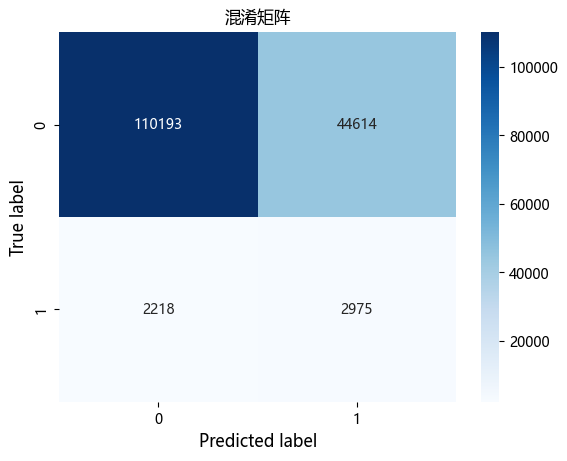

In [36]:
# 训练模型
final_lr = LogisticRegression(penalty='l2',C=1,class_weight='balanced',solver='lbfgs',random_state=0)
final_lr.fit(X_resampled,y_resampled)
# 预测值要拿交叉验证的验证集进行验证
# 直接预测类别值
y_resampled_pred = final_lr.predict(X_test)
# 计算混淆矩阵
cm = confusion_matrix(y_test,y_resampled_pred)
print('混淆矩阵：')
print(cm)
# 绘制热力图可视化混淆矩阵
sns.heatmap(cm,annot=True,cbar_kws={'format': '%.0f'},fmt='.0f',cmap="Blues")
plt.title("混淆矩阵")
plt.xlabel("Predicted label",fontsize=12)
plt.ylabel("True label",fontsize=12)
plt.show()

In [37]:
# 分类报告
report = classification_report(y_test,y_resampled_pred)
print('分类报告')
print(report)

分类报告
              precision    recall  f1-score   support

           0       0.98      0.71      0.82    154807
           1       0.06      0.57      0.11      5193

    accuracy                           0.71    160000
   macro avg       0.52      0.64      0.47    160000
weighted avg       0.95      0.71      0.80    160000



#### 选取不同阈值然后观测recall、precision、f1等指标的变化，选择最优的阈值

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Threshold=0.1 | Recall = 1.00 | Precision = 0.03 | F1 = 3.00
Threshold=0.2 | Recall = 1.00 | Precision = 0.03 | F1 = 3.00
Threshold=0.3 | Recall = 0.99 | Precision = 0.03 | F1 = 2.98
Threshold=0.4 | Recall = 0.76 | Precision = 0.05 | F1 = 2.29
Threshold=0.5 | Recall = 0.57 | Precision = 0.06 | F1 = 1.72
Threshold=0.6 | Recall = 0.42 | Precision = 0.07 | F1 = 1.26
Threshold=0.7 | Recall = 0.24 | Precision = 0.08 | F1 = 0.71
Threshold=0.8 | Recall = 0.06 | Precision = 0.10 | F1 = 0.18
Threshold=0.9 | Recall = 0.00 | Precision = 0.10 | F1 = 0.00


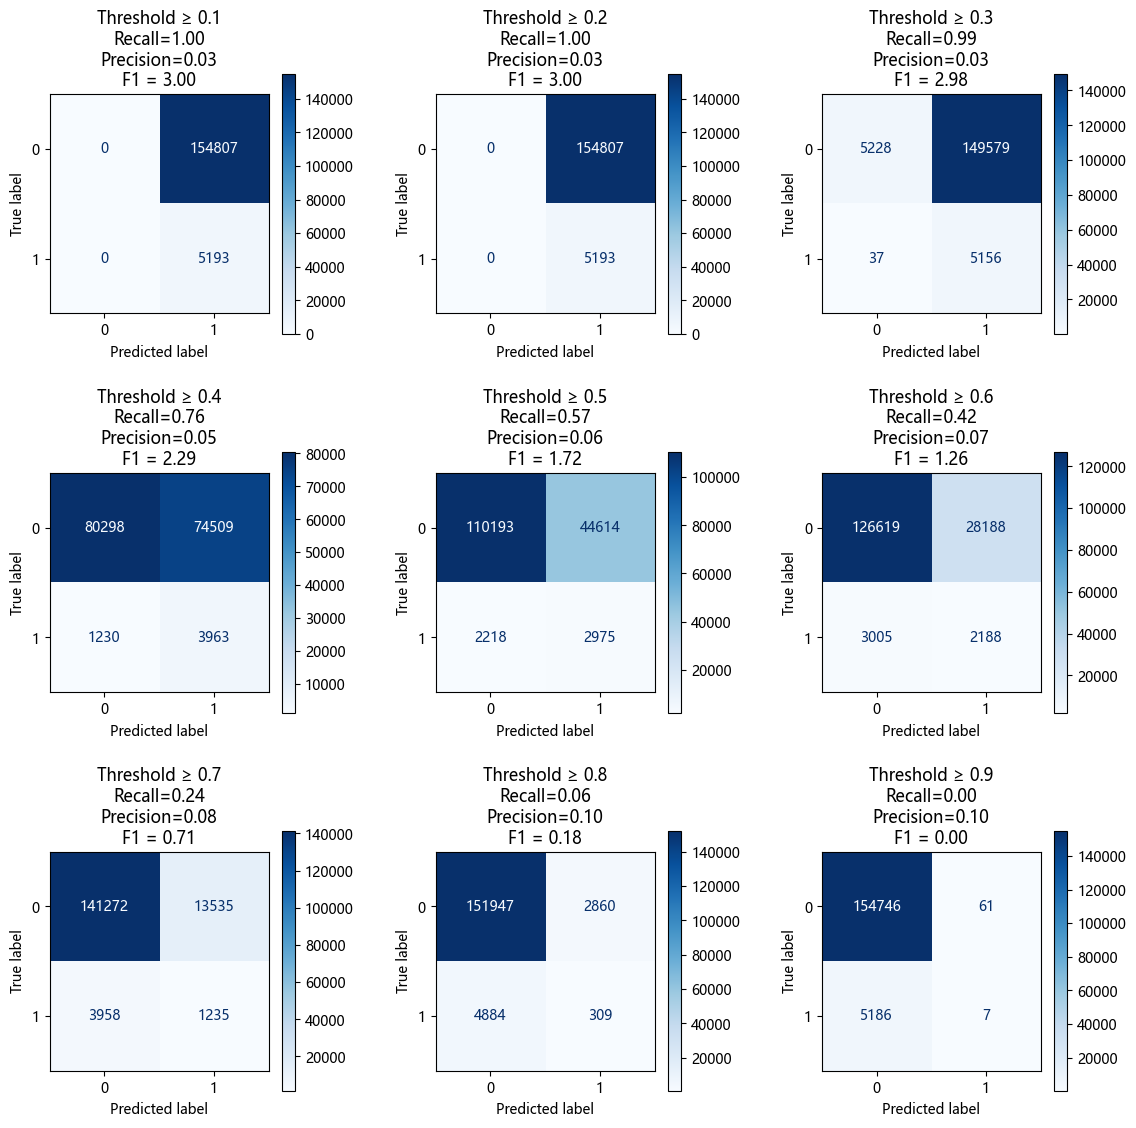

In [39]:
# 获取每个样本预测为正例的概率值（第二列）
y_resampled_pred_proba = final_lr.predict_proba(X_test)[:,1]
# 设置阈值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# 创建一个 3x3 的画布，用于放置 9 个子图
plt.figure(figsize=(12,12))

# 循环遍历每个阈值（enumerate获取序列元素时，同时得到它的索引）
for index,thr in enumerate(thresholds,start=1):
    # 根据阈值转化概率为二分类预测结果(这行代码返回的是True/False的布尔型数组)
    y_pred_result = (y_resampled_pred_proba >= thr).astype(int)
    # 计算混淆矩阵，格式为 [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_test,y_pred_result)
    # 从混淆矩阵中提取三要素(ravel将矩阵“拍平”成一维数组)
    tn, fp, fn, tp = cm.ravel()
    recall = tp/(tp+fn) # recall = TP / (TP + FN)
    precision = tp/(tp+fp)
    f1 = (2 * (precision * recall))/precision + recall
    # 打印当前阈值对应的 recall
    print(f'Threshold={thr:.1f} | Recall = {recall:.2f} | Precision = {precision:.2f} | F1 = {f1:.2f}')
    # 新增子图（3行3列中的位置）
    ax = plt.subplot(3, 3, index)
    # 使用 sklearn 的 ConfusionMatrixDisplay 绘图（推荐方式）  
    # ConfusionMatrixDisplay 是 sklearn 中用于混淆矩阵可视化的类，它支持直接传入 cm 和标签绘图 :contentReference[oaicite:1]{index=1}
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0, 1])
    disp.plot(ax=ax,cmap=plt.cm.Blues,values_format='d')
    ax.set_title(f"Threshold ≥ {thr:.1f}\nRecall={recall:.2f}\nPrecision={precision:.2f}\nF1 = {f1:.2f}")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
# 调整子图布局，避免重叠
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.9)
plt.show() 

根据上面的混淆矩阵热力图发现，阈值在0.5，0.6区间表现比较好，但是还是模型结果仍然不够好所以我们尝试一下其他分类模型。

### 使用随机森林模型训练过采样数据集，测试数据，最终查看模型表现效果

In [40]:
cleaned_data_2

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Is_repurchase,Coupon_time_13-18点,Coupon_time_19-24点,Coupon_time_7-12点
0,58720256,1,1,25,6,21,6,12,2,31,19,0,0,1,0
1,94371845,6,6,147,55,111,0,30,18,33,10,0,1,0,0
2,27262983,3,2,85,23,47,0,36,6,35,25,0,0,0,1
3,75497485,2,2,44,16,70,4,26,5,33,21,0,0,0,0
4,33554447,1,1,9,3,6,0,0,0,31,19,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,81788906,2,1,31,22,44,2,22,4,321,17,0,0,1,0
799996,12582899,1,1,17,9,18,8,4,3,373,13,0,0,0,0
799997,20971508,7,7,91,43,87,18,0,14,382,210,0,1,0,0
799998,56623094,3,2,90,13,53,12,33,4,355,133,0,0,1,0


In [41]:
# 将X，y进行切分
X_2 = cleaned_data_2[num_cols]
y_2 = cleaned_data_2['Is_repurchase']

In [42]:
# 建立相关系数矩阵
corr_matrix = X_2.corr().abs()
corr_matrix

,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days
Order_num,1.000000,0.976911,0.874792,0.858551,0.703382,0.601403,0.571349,0.556180,0.000246,0.000524
Coupon_order,0.976911,1.000000,0.854616,0.838953,0.678967,0.582782,0.557908,0.543291,0.000317,0.000275
Order_amount,0.874792,0.854616,1.000000,0.756646,0.620428,0.526540,0.499589,0.485596,0.000333,0.000648
Browse_product,0.858551,0.838953,0.756646,1.000000,0.787836,0.669504,0.489010,0.640075,0.000390,0.000392
Browse_duration,0.703382,0.678967,0.620428,0.787836,1.000000,0.585813,0.401262,0.503229,0.000558,0.000087
Cart_product,0.601403,0.582782,0.526540,0.669504,0.585813,1.000000,0.342852,0.434756,0.000445,0.000576
Livestream_duration,0.571349,0.557908,0.499589,0.489010,0.401262,0.342852,1.000000,0.316867,0.002218,0.001503
Search_count,0.556180,0.543291,0.485596,0.640075,0.503229,0.434756,0.316867,1.000000,0.000795,0.001516
Buy_gap_days,0.000246,0.000317,0.000333,0.000390,0.000558,0.000445,0.002218,0.000795,1.000000,0.397246
Browse_gap_days,0.000524,0.000275,0.000648,0.000392,0.000087,0.000576,0.001503,0.001516,0.397246,1.000000


#### 组合构造新特征，消除高相关性

从上面相关系数矩阵中可以观察到Order_num（订单数）和Coupon_order(使用优惠券的订单数)呈现高相关，可以考虑将相关性高的特征组合，创造新特征：Coupon_rate(使用优惠券的转化率) = Coupon_order(使用优惠券的订单数) / Order_num（订单数），Order_num（订单数）和Order_amount(订单金额)呈现高相关，同样创造新特征：Average_order_amount(平均订单金额) = Order_amount(订单金额) / Order_num（订单数）以及Order_num（订单数）和Browse_product（浏览商品数量）呈现高相关，同样创造新特征：Browse_per_order（每单平均浏览数）= Browse_product（浏览商品数量）/ Order_num（订单数）。这样做可以提高模型解释性和稳定的特征重要性评估。

In [43]:
# 构建新的特征列，使用优惠券的订单数 / 订单数 = 使用优惠券的转化率
X_2['Coupon_rate'] = X_2['Coupon_order'] / X_2['Order_num']
# 将新的特征列控制在小数点后2位
X_2['Coupon_rate'] = X_2['Coupon_rate'].round(2)
# 删除优惠券的订单数这个特征列
X_2 = X_2.drop('Coupon_order',axis=1)
# 构建新的特征列，订单金额 / 订单数 = 平均订单金额
X_2['Average_order_amount'] = X_2['Order_amount'] / X_2['Order_num']
# 将新的特征列控制在小数点后2位
X_2['Average_order_amount'] = X_2['Average_order_amount'].round(2)
# 删除平均订单金额这个特征列
X_2 = X_2.drop('Order_amount',axis=1)
# 构建新的特征列，浏览商品数量/ 订单数 = 每单平均浏览数
X_2['Browse_per_order'] = X_2['Browse_product'] / X_2['Order_num']
# 将新的特征列控制在小数点后2位
X_2['Browse_per_order'] = X_2['Browse_per_order'].round(2)
# 删除浏览商品数量这个特征列
X_2 = X_2.drop('Browse_product',axis=1)
# 再次查看新特征列与原特征列的相关系数
corr_matrix = X_2.corr().abs()
corr_matrix

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\969335252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['Coupon_rate'] = X_2['Coupon_order'] / X_2['Order_num']
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\969335252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['Coupon_rate'] = X_2['Coupon_rate'].round(2)


,Order_num,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_rate,Average_order_amount,Browse_per_order
Order_num,1.000000,0.703382,0.601403,0.571349,0.556180,0.000246,0.000524,0.087854,0.047696,0.090211
Browse_duration,0.703382,1.000000,0.585813,0.401262,0.503229,0.000558,0.000087,0.100493,0.047059,0.439837
Cart_product,0.601403,0.585813,1.000000,0.342852,0.434756,0.000445,0.000576,0.074495,0.031378,0.349467
Livestream_duration,0.571349,0.401262,0.342852,1.000000,0.316867,0.002218,0.001503,0.051235,0.026826,0.050713
Search_count,0.556180,0.503229,0.434756,0.316867,1.000000,0.000795,0.001516,0.049163,0.025875,0.305598
Buy_gap_days,0.000246,0.000558,0.000445,0.002218,0.000795,1.000000,0.397246,0.002435,0.000526,0.000009
Browse_gap_days,0.000524,0.000087,0.000576,0.001503,0.001516,0.397246,1.000000,0.001156,0.000842,0.000085
Coupon_rate,0.087854,0.100493,0.074495,0.051235,0.049163,0.002435,0.001156,1.000000,0.013411,0.028246
Average_order_amount,0.047696,0.047059,0.031378,0.026826,0.025875,0.000526,0.000842,0.013411,1.000000,0.025895
Browse_per_order,0.090211,0.439837,0.349467,0.050713,0.305598,0.000009,0.000085,0.028246,0.025895,1.000000


In [44]:
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# 对原始数据进行切分,划分训练集和测试集
X_2_train,X_2_test,y_2_train,y_2_test = train_test_split(X_2,y_2,test_size=0.2,random_state=0)
# cross_val_score + Pipeline 已经自动在每个 fold 做 SMOTE
pipeline = Pipeline([
    ('smote_2',SMOTE(random_state = 0)),
    ('rf_model',RandomForestClassifier(random_state = 0,max_depth=20,n_estimators=100,min_samples_split=20,min_samples_leaf=10,class_weight='balanced'))
])
# 定义KFold交叉验证(shuffle=True：在划分数据之前，先对数据进行随机打乱。)
kf_2 = KFold(n_splits=3,shuffle=True,random_state=0)
scores_2 = cross_val_score(pipeline,X_2_train,y_2_train,cv=kf_2,scoring='recall')
print('平均recall值：',scores.mean())

平均recall值： 0.5686373031453877


In [45]:
#使用smote生成样本，使得样本均匀
smote_2 = SMOTE(random_state = 0)
X_2_resampled, y_2_resampled=smote_2.fit_resample(X_2_train,y_2_train)
print(f"原始类别分布：\n{y_train.value_counts()}")
print(f"平衡后的类别分布：\n{y_resampled.value_counts()}")

原始类别分布：
Is_repurchase
0                618696
1                 21304
Name: count, dtype: int64
平衡后的类别分布：
Is_repurchase
0                618696
1                618696
Name: count, dtype: int64


混淆矩阵2：
[[142545  12262]
 [  4230    963]]


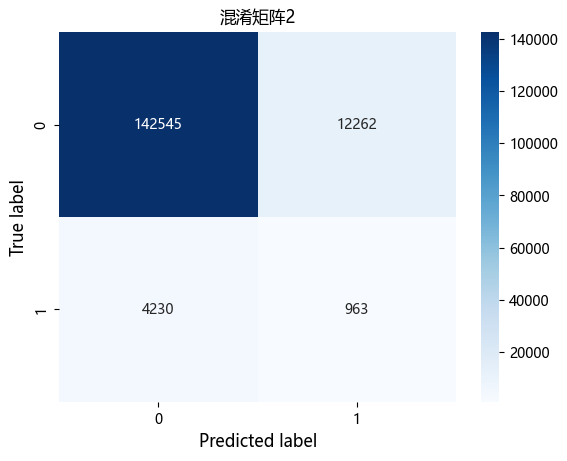

In [46]:
# 训练模型
rf_model = RandomForestClassifier(random_state = 0,max_depth=20,n_estimators=100,min_samples_split=20,min_samples_leaf=10,n_jobs=-1,class_weight='balanced')
rf_model.fit(X_2_resampled, y_2_resampled)
# 预测值要拿交叉验证的验证集进行验证
y_2_pred = rf_model.predict(X_2_test)
# 计算混淆矩阵
cm2 = confusion_matrix(y_2_test,y_2_pred)
print('混淆矩阵2：')
print(cm2)
# 绘制热力图可视化混淆矩阵
sns.heatmap(cm2,annot=True,cbar_kws={'format': '%.0f'},fmt='.0f',cmap="Blues")
plt.title("混淆矩阵2")
plt.xlabel("Predicted label",fontsize=12)
plt.ylabel("True label",fontsize=12)
plt.show()

In [47]:
# 分类报告
report2 = classification_report(y_2_test,y_2_pred)
print('分类报告2')
print(report2)

分类报告2
              precision    recall  f1-score   support

           0       0.97      0.92      0.95    154807
           1       0.07      0.19      0.10      5193

    accuracy                           0.90    160000
   macro avg       0.52      0.55      0.52    160000
weighted avg       0.94      0.90      0.92    160000



Threshold=0.1 | Recall = 0.87 | Precision = 0.04 | F1 = 2.61
Threshold=0.2 | Recall = 0.64 | Precision = 0.04 | F1 = 1.93
Threshold=0.3 | Recall = 0.42 | Precision = 0.05 | F1 = 1.27
Threshold=0.4 | Recall = 0.28 | Precision = 0.06 | F1 = 0.85
Threshold=0.5 | Recall = 0.19 | Precision = 0.07 | F1 = 0.56
Threshold=0.6 | Recall = 0.09 | Precision = 0.07 | F1 = 0.28
Threshold=0.7 | Recall = 0.01 | Precision = 0.08 | F1 = 0.04
Threshold=0.8 | Recall = 0.00 | Precision = 0.03 | F1 = 0.00
Threshold=0.9 | Recall = 0.00 | Precision = 0.00 | F1 = nan


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\2421731457.py:18: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2 * (precision * recall))/precision + recall


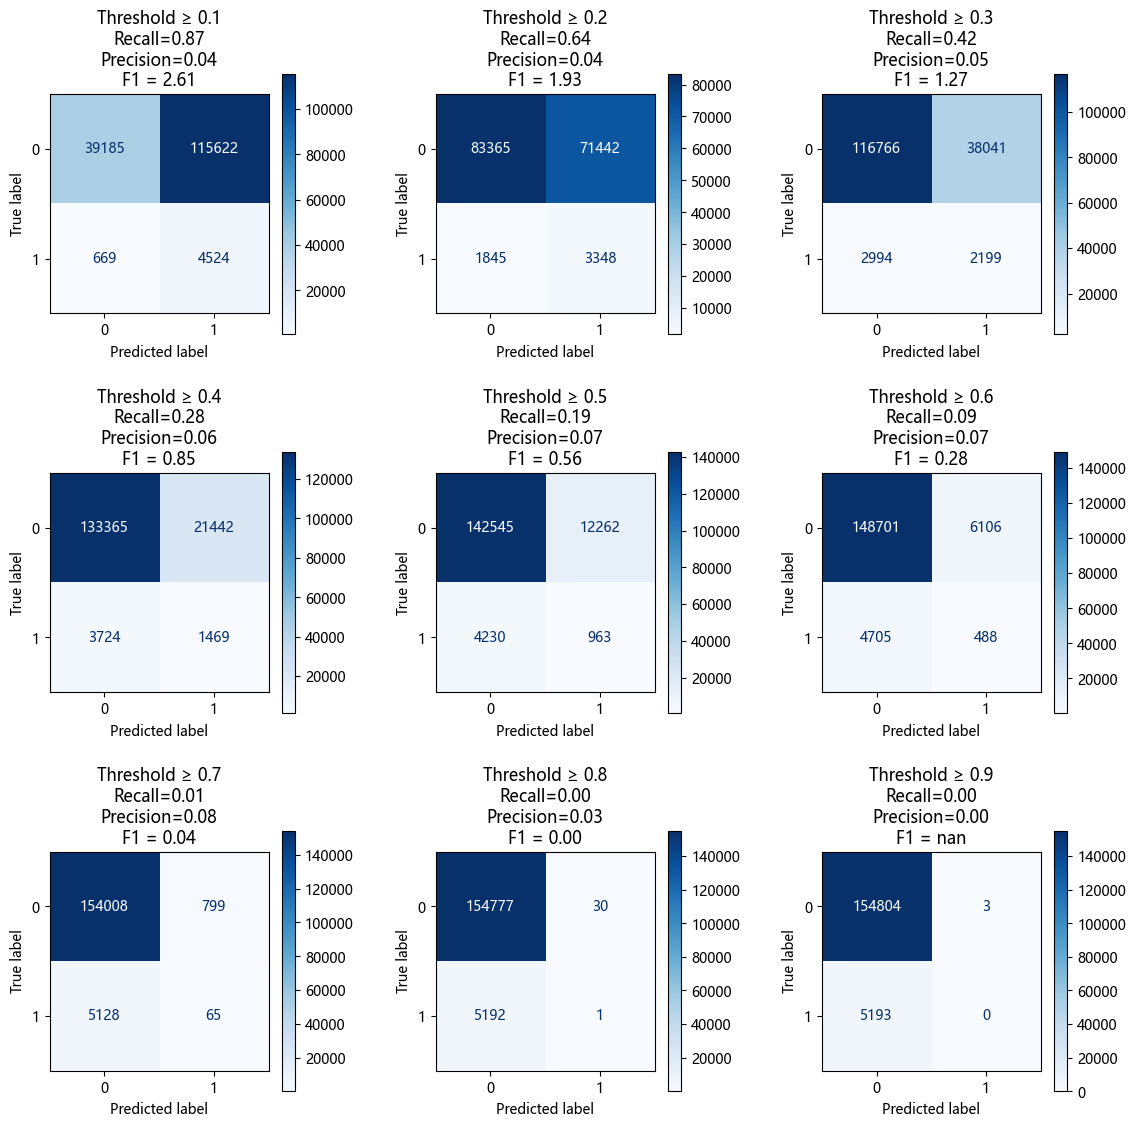

In [48]:
# 获取每个样本预测为正例的概率值（第二列）
y_2_resampled_pred_proba = rf_model.predict_proba(X_2_test)[:,1]
# 设置阈值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# 创建一个 3x3 的画布，用于放置 9 个子图
plt.figure(figsize=(12,12))

# 循环遍历每个阈值（enumerate获取序列元素时，同时得到它的索引）
for index,thr in enumerate(thresholds,start=1):
    # 根据阈值转化概率为二分类预测结果(这行代码返回的是True/False的布尔型数组)
    y_2_pred_result = (y_2_resampled_pred_proba >= thr).astype(int)
    # 计算混淆矩阵，格式为 [[TN, FP], [FN, TP]]
    cm2 = confusion_matrix(y_2_test,y_2_pred_result)
    # 从混淆矩阵中提取三要素(ravel将矩阵“拍平”成一维数组)
    tn, fp, fn, tp = cm2.ravel()
    recall = tp/(tp+fn) # recall = TP / (TP + FN)
    precision = tp/(tp+fp)
    f1 = (2 * (precision * recall))/precision + recall
    # 打印当前阈值对应的 recall
    print(f'Threshold={thr:.1f} | Recall = {recall:.2f} | Precision = {precision:.2f} | F1 = {f1:.2f}')
    # 新增子图（3行3列中的位置）
    ax = plt.subplot(3, 3, index)
    # 使用 sklearn 的 ConfusionMatrixDisplay 绘图（推荐方式）  
    # ConfusionMatrixDisplay 是 sklearn 中用于混淆矩阵可视化的类，它支持直接传入 cm 和标签绘图 :contentReference[oaicite:1]{index=1}
    disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=[0, 1])
    disp.plot(ax=ax,cmap=plt.cm.Blues,values_format='d')
    ax.set_title(f"Threshold ≥ {thr:.1f}\nRecall={recall:.2f}\nPrecision={precision:.2f}\nF1 = {f1:.2f}")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
# 调整子图布局，避免重叠
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.9)
plt.show() 

随机森林预测效果还是很差，误杀率非常高，同时有大量的数据没有被预测出来，接下来尝试一下别的模型。

### 使用XGboost模型训练过采样数据集，测试数据，最终查看模型表现效果

In [49]:
from xgboost import XGBClassifier
XG_model = XGBClassifier(n_estimators=1000, max_depth=20, learning_rate=0.05,
    use_label_encoder=False,verbose=True, eval_metric='logloss',
    early_stopping_rounds=10, random_state=0, n_jobs=-1,min_child_weight=1,scale_pos_weight=1)
eval_set = [(X_2_test,y_2_test)]
XG_model.fit(X_2_resampled, y_2_resampled,eval_set=[(X_2_test, y_2_test)],
    verbose=True)
y_3_pred = XG_model.predict(X_2_test)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [14:34:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-logloss:0.66427
[1]	validation_0-logloss:0.63652
[2]	validation_0-logloss:0.61139
[3]	validation_0-logloss:0.58828
[4]	validation_0-logloss:0.56708
[5]	validation_0-logloss:0.54748
[6]	validation_0-logloss:0.52922
[7]	validation_0-logloss:0.51177
[8]	validation_0-logloss:0.49586
[9]	validation_0-logloss:0.48121
[10]	validation_0-logloss:0.46747
[11]	validation_0-logloss:0.45427
[12]	validation_0-logloss:0.44229
[13]	validation_0-logloss:0.43030
[14]	validation_0-logloss:0.41901
[15]	validation_0-logloss:0.40839
[16]	validation_0-logloss:0.39903
[17]	validation_0-logloss:0.38992
[18]	validation_0-logloss:0.38104
[19]	validation_0-logloss:0.37302
[20]	validation_0-logloss:0.36542
[21]	validation_0-logloss:0.35820
[22]	validation_0-logloss:0.35135
[23]	validation_0-logloss:0.34487
[24]	validation_0-logloss:0.33863
[25]	validation_0-logloss:0.33261
[26]	validation_0-logloss:0.32684
[27]	validation_0-logloss:0.32144
[28]	validation_0-logloss:0.31637
[29]	validation_0-loglos

In [50]:
print("best_iteration:", XG_model.best_iteration)
print("best_score:", XG_model.best_score)

best_iteration: 373
best_score: 0.15526481180447443


混淆矩阵3：
[[154379    428]
 [  5160     33]]


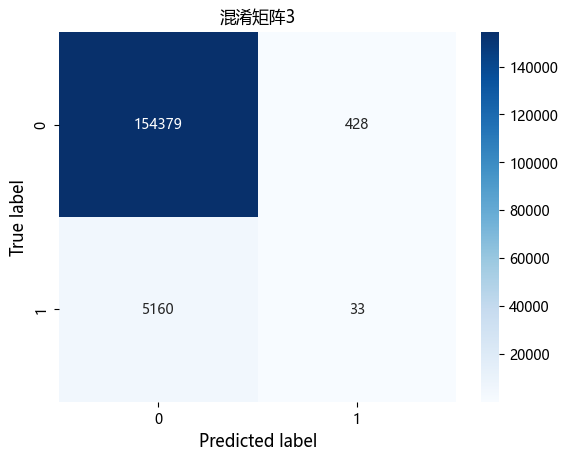

In [51]:
# 计算混淆矩阵
cm3 = confusion_matrix(y_2_test,y_3_pred)
print('混淆矩阵3：')
print(cm3)
# 绘制热力图可视化混淆矩阵
sns.heatmap(cm3,annot=True,cbar_kws={'format': '%.0f'},fmt='.0f',cmap="Blues")
plt.title("混淆矩阵3")
plt.xlabel("Predicted label",fontsize=12)
plt.ylabel("True label",fontsize=12)
plt.show()

In [52]:
# 分类报告
report3 = classification_report(y_2_test,y_3_pred)
print('分类报告3')
print(report3)

分类报告3
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    154807
           1       0.07      0.01      0.01      5193

    accuracy                           0.97    160000
   macro avg       0.52      0.50      0.50    160000
weighted avg       0.94      0.97      0.95    160000



Threshold=0.1 | Recall = 0.20 | Precision = 0.07 | F1 = 0.61
Threshold=0.2 | Recall = 0.08 | Precision = 0.07 | F1 = 0.25
Threshold=0.3 | Recall = 0.04 | Precision = 0.08 | F1 = 0.12
Threshold=0.4 | Recall = 0.02 | Precision = 0.07 | F1 = 0.05
Threshold=0.5 | Recall = 0.01 | Precision = 0.07 | F1 = 0.02
Threshold=0.6 | Recall = 0.00 | Precision = 0.07 | F1 = 0.01
Threshold=0.7 | Recall = 0.00 | Precision = 0.09 | F1 = 0.00
Threshold=0.8 | Recall = 0.00 | Precision = 0.00 | F1 = nan
Threshold=0.9 | Recall = 0.00 | Precision = 0.00 | F1 = nan


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\1883719227.py:18: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2 * (precision * recall))/precision + recall
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\1883719227.py:18: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2 * (precision * recall))/precision + recall


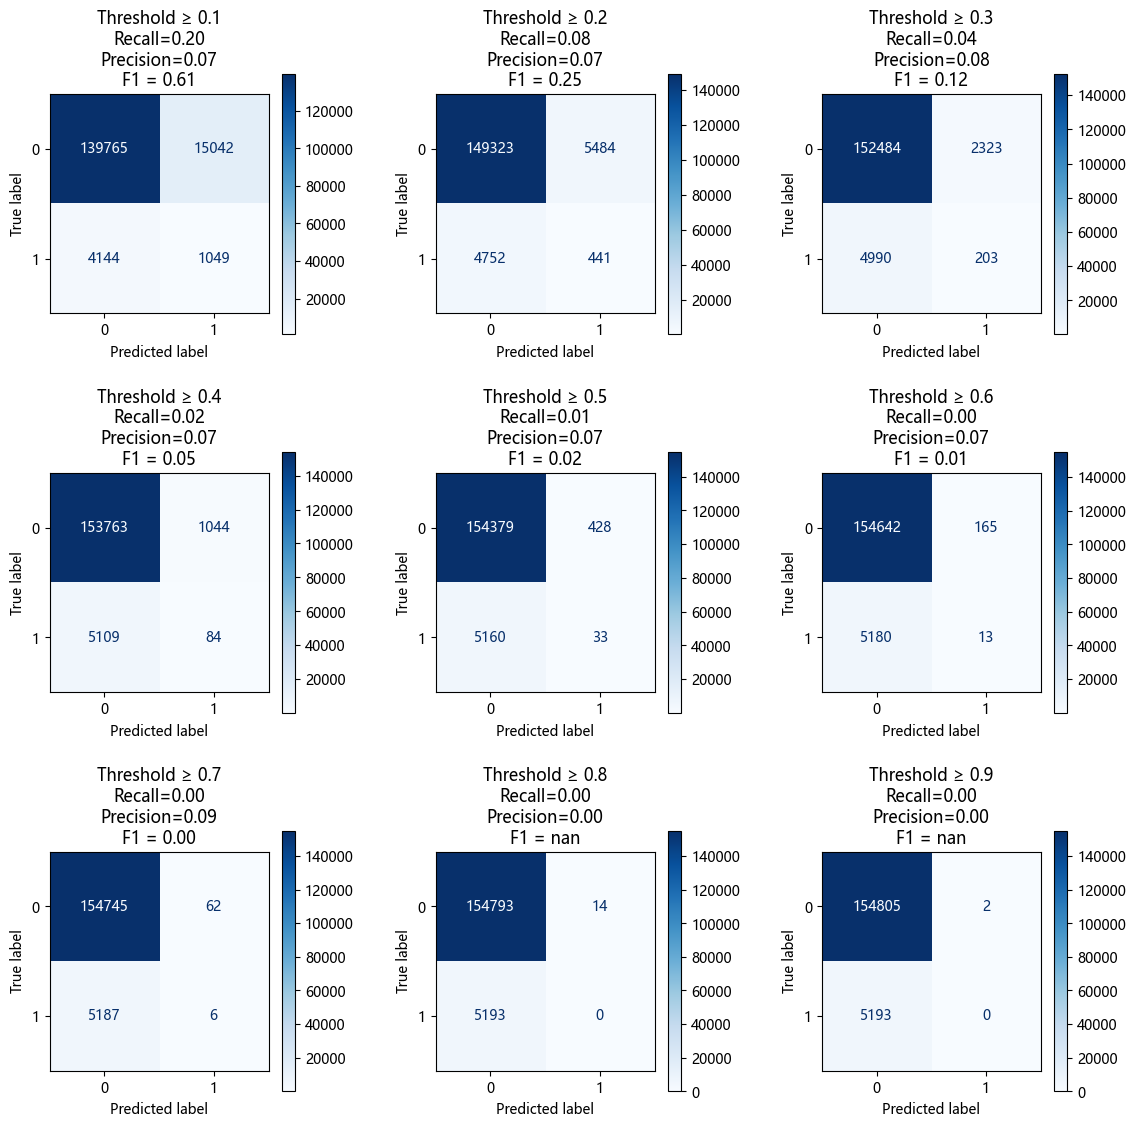

In [53]:
# 获取每个样本预测为正例的概率值（第二列）
y_3_resampled_pred_proba = XG_model.predict_proba(X_2_test)[:,1]
# 设置阈值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# 创建一个 3x3 的画布，用于放置 9 个子图
plt.figure(figsize=(12,12))

# 循环遍历每个阈值（enumerate获取序列元素时，同时得到它的索引）
for index,thr in enumerate(thresholds,start=1):
    # 根据阈值转化概率为二分类预测结果(这行代码返回的是True/False的布尔型数组)
    y_3_pred_result = (y_3_resampled_pred_proba >= thr).astype(int)
    # 计算混淆矩阵，格式为 [[TN, FP], [FN, TP]]
    cm3 = confusion_matrix(y_2_test,y_3_pred_result)
    # 从混淆矩阵中提取三要素(ravel将矩阵“拍平”成一维数组)
    tn, fp, fn, tp = cm3.ravel()
    recall = tp/(tp+fn) # recall = TP / (TP + FN)
    precision = tp/(tp+fp)
    f1 = (2 * (precision * recall))/precision + recall
    # 打印当前阈值对应的 recall
    print(f'Threshold={thr:.1f} | Recall = {recall:.2f} | Precision = {precision:.2f} | F1 = {f1:.2f}')
    # 新增子图（3行3列中的位置）
    ax = plt.subplot(3, 3, index)
    # 使用 sklearn 的 ConfusionMatrixDisplay 绘图（推荐方式）  
    # ConfusionMatrixDisplay 是 sklearn 中用于混淆矩阵可视化的类，它支持直接传入 cm 和标签绘图 :contentReference[oaicite:1]{index=1}
    disp = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=[0, 1])
    disp.plot(ax=ax,cmap=plt.cm.Blues,values_format='d')
    ax.set_title(f"Threshold ≥ {thr:.1f}\nRecall={recall:.2f}\nPrecision={precision:.2f}\nF1 = {f1:.2f}")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
# 调整子图布局，避免重叠
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.9)
plt.show() 

XGboost预测效果还是很差。误杀率非常高，同时有大量的数据没有被预测出来。综合以上对数据建立分类模型对数据进行探索，各类模型均没有达到预期效果，分析原因大概率是应该少数类（Y=0）样本特征信息不足的原因,所以在接下来暂不进行重要特征特性提取等后续的分析动作，先根据上述发现7-12点这个时间段转化率低进行提出进一步优化措施。

## 1、业务背景

分析数据发现，领取回归礼券时间在上午的7-12点的用户，领券后的下单转化率低于其他时段的下单转化率。运营同事考虑缩短上午7-12点发放的召回礼券有效期，设计了下面的AB实验。  
对照组：召回礼券的有效期12小时  
实验组1：召回礼券的有效期调整为4小时  
实验组2：召回礼券的有效期调整为2小时

## 2、数据

AB实验数据  
User_id：用户ID  
Group：分组  
Coupon_time：领取回归礼券的时间段（7-12点）  
   
（以下为领取召回券前的行为数据）  
Buy_gap_days：领取召回券与前一次下单间隔天数  
Browse_gap_days：领取召回券与前一次浏览商城间隔天数  
Browse_duration：浏览商城时长（分钟）  
Browse_product：浏览商品数量  
Cart_product：加购商品数  
Livestream_duration：观看商城直播时长  
Search_count：商城搜索次数  
Order_num：订单数  
Order_amount：订单金额  
Coupon_order：使用优惠券的订单数  
   
Is_repurchase：是否使用召回礼券  

## 3、整理数据

导入数据分析所需要的库，并通过Pandas的`read_csv`函数，将原始数据文件`ab_test_results.csv`里的数据内容，解析为DataFrame并赋值给变量`original_data_2`。

In [54]:
original_data_2 = pd.read_csv('ab_test_results.csv')
original_data_2

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2


### 评估和清理数据

在这一部分中，我们将对在上一部分建立的`original_data_2`DataFrame所包含的数据进行评估和清理。
主要从两个方面进行：结构和内容，即整齐度和干净度。
数据的结构性问题指不符合“每个变量为一列，每个观察值为一行，每种类型的观察单位为一个表格”这三个标准；数据的内容性问题包括存在丢失数据、重复数据、无效数据等。

为了区分开经过清理的数据和原始的数据，我们创建新的变量cleaned_data_3，让它为original_data_2复制出的副本。我们之后的清理步骤都将被运用在cleaned_data_3上。

In [55]:
cleaned_data_3 = original_data_2.copy()

### 数据整齐度

In [56]:
cleaned_data_3.head(10)

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组
5,295174152,1,1,6,4,9,0,0,2,75,10,7-12点,0,对照组
6,287834119,1,1,7,3,7,0,0,1,127,15,7-12点,0,对照组
7,371195916,1,1,11,1,8,0,0,1,85,40,7-12点,0,对照组
8,287309837,1,1,15,3,7,2,3,2,99,83,7-12点,0,对照组
9,164626446,1,1,13,6,12,1,3,0,135,17,7-12点,0,对照组


从头部的10行数据来看，数据符合“每个变量为一列，每个观察值为一行，每种类型的观察单位为一个表格”，因此不存在结构性问题。

### 数据干净度

接下来通过info，对数据内容进行大致了解。

In [57]:
cleaned_data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_id              300000 non-null  int64 
 1   Order_num            300000 non-null  int64 
 2   Coupon_order         300000 non-null  int64 
 3   Order_amount         300000 non-null  int64 
 4   Browse_product       300000 non-null  int64 
 5   Browse_duration      300000 non-null  int64 
 6   Cart_product         300000 non-null  int64 
 7   Livestream_duration  300000 non-null  int64 
 8   Search_count         300000 non-null  int64 
 9   Buy_gap_days         300000 non-null  int64 
 10  Browse_gap_days      300000 non-null  int64 
 11  Coupon_time          300000 non-null  object
 12  Is_repurchase        300000 non-null  int64 
 13  Group                300000 non-null  object
dtypes: int64(12), object(2)
memory usage: 32.0+ MB


从输出结果来看，cleaned_data_3数据共有30000条观察值，不存在缺失值。  
User_id表示样本ID，数据类型不应为数字，应为字符串，所以需要进行数据格式转换。  
Coupon_time和Group为分类数据，应该转换为category数据类型，节约内存空间。

In [58]:
cleaned_data_3['User_id'] = cleaned_data_3['User_id'].astype(str)
cleaned_data_3['Coupon_time'] = cleaned_data_3['Coupon_time'].astype('category')
cleaned_data_3['Group'] = cleaned_data_3['Group'].astype('category')

In [59]:
cleaned_data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   User_id              300000 non-null  object  
 1   Order_num            300000 non-null  int64   
 2   Coupon_order         300000 non-null  int64   
 3   Order_amount         300000 non-null  int64   
 4   Browse_product       300000 non-null  int64   
 5   Browse_duration      300000 non-null  int64   
 6   Cart_product         300000 non-null  int64   
 7   Livestream_duration  300000 non-null  int64   
 8   Search_count         300000 non-null  int64   
 9   Buy_gap_days         300000 non-null  int64   
 10  Browse_gap_days      300000 non-null  int64   
 11  Coupon_time          300000 non-null  category
 12  Is_repurchase        300000 non-null  int64   
 13  Group                300000 non-null  category
dtypes: category(2), int64(11), object(1)
memory usage: 2

#### 处理缺失数据

从info方法的输出结果来看，cleaned_data_3不存在缺失值，因此不需要对缺失数据进行处理。

#### 处理重复数据

根据数据变量的含义以及内容来看，cleaned_data_3里的Userid是样本的唯一标识符，不应该存在重复，因此查看是否存在重复值。

In [60]:
cleaned_data_3['User_id'].duplicated().sum()

0

输出结果为0，说明不存在重复值。

#### 处理不一致数据

不一致数据可能存在于Coupon_time和Group这两个变量中，我们要查看是否存在多个不同值指代同一种类的情况。

In [61]:
cleaned_data_3['Coupon_time'].value_counts()

Coupon_time
7-12点    300000
Name: count, dtype: int64

In [62]:
cleaned_data_3['Group'].value_counts()

Group
实验组1    100000
实验组2    100000
对照组     100000
Name: count, dtype: int64

从以上输出结果来看，Coupon_time只有一种类型的值（7-12点），不存在不一致数据。Group只有三种类型的值（实验组1、实验组2、对照组），不存在不一致数据。

#### 处理无效或错误数据

可以通过DataFrame的describe方法，对数值统计信息进行快速了解。

In [63]:
cleaned_data_3.describe()

,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Is_repurchase
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,2.473263,2.292760,44.423177,18.932063,56.648413,9.696430,13.934280,3.519590,84.559630,33.351453,0.031567
std,1.796601,1.740102,37.539703,16.848006,47.050014,10.127988,17.813258,4.230998,46.756857,25.634268,0.174844
min,1.000000,1.000000,5.000000,1.000000,3.000000,0.000000,0.000000,0.000000,31.000000,1.000000,0.000000
25%,1.000000,1.000000,19.000000,7.000000,20.000000,3.000000,0.000000,0.000000,48.000000,15.000000,0.000000
50%,2.000000,2.000000,31.000000,13.000000,39.000000,6.000000,8.000000,2.000000,72.000000,27.000000,0.000000
75%,3.000000,3.000000,57.000000,25.000000,84.000000,13.000000,20.000000,5.000000,109.000000,44.000000,0.000000
max,10.000000,10.000000,322.000000,149.000000,198.000000,53.000000,140.000000,46.000000,391.000000,318.000000,1.000000


从以上统计信息来看，cleaned_data里不存在脱离现实意义的数值。

## 问题2：数据分析师需分析召回礼券的有效期缩短是否能提高转化率？有效期缩短对哪种特征的用户刺激转化的效果最大？

### 召回礼券的有效期缩短是否能提高转化率

In [64]:
cleaned_data_3

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2


In [65]:
# 查看各个组即各种召回礼券有效时长的使用率
Is_repurchase_based_on_cleaned_data_Group = cleaned_data_3.groupby('Group').agg(reuse = ('Is_repurchase','sum') ,total=('Is_repurchase','count')).reset_index()
Is_repurchase_based_on_cleaned_data_Group['reuse_rate'] = Is_repurchase_based_on_cleaned_data_Group['reuse'] / Is_repurchase_based_on_cleaned_data_Group['total']
Is_repurchase_based_on_cleaned_data_Group

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8544\2520666799.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Is_repurchase_based_on_cleaned_data_Group = cleaned_data_3.groupby('Group').agg(reuse = ('Is_repurchase','sum') ,total=('Is_repurchase','count')).reset_index()


,Group,reuse,total,reuse_rate
0,实验组1,3269,100000,0.03269
1,实验组2,3205,100000,0.03205
2,对照组,2996,100000,0.02996


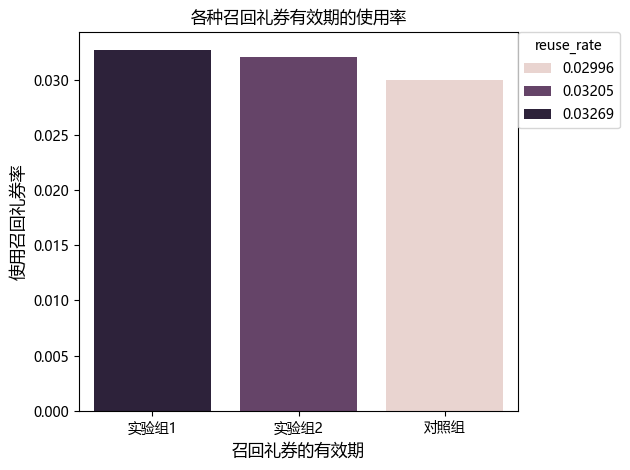

In [66]:
#画柱状图
ax = sns.barplot(data=Is_repurchase_based_on_cleaned_data_Group,x='Group',y='reuse_rate',hue='reuse_rate')
#添加标题和标签
plt.title("各种召回礼券有效期的使用率")
plt.xlabel("召回礼券的有效期",fontsize=12)
plt.ylabel("使用召回礼券率",fontsize=12)
#设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']   
#图例移到图外右侧
sns.move_legend(
    ax,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    borderaxespad=0.
)
#显示图表
plt.tight_layout()
plt.show()

根据不同实验组的召回礼券使用率中可以发现减少召回礼券有效期确实有提高使用率，接下来要对各组的转化率进行假设检验。

### 假设检验

我们将利用假设检验，检验三个实验即（召回礼券的有效期12小时、4小时、2小时）在使用召回礼券率方面两两是否存在统计显著性差异。
我们采用卡方独立性检验，先引入卡方独立性检验所需要的模块。

In [67]:
from itertools import combinations

In [68]:
# 构建列联表：行是领取回归礼券的时间段，列是是否使用召回礼券率（0或1）
contingency_table_2 = pd.crosstab(cleaned_data_3['Group'],cleaned_data_3['Is_repurchase'])

# 整体卡方检验
chi2,p,dof,expected = chi2_contingency(contingency_table_2)
print(f"整体卡方：χ²={chi2:.4f}, p={p:.4f}")

# 两两比较
groups = contingency_table_2.index.tolist()
# 这行代码的意思是拿 groups （即你所有的组名，如 ['12小时', '4小时', '2小时']）生成所有可能的两两组合（pairwise combinations），并把它们放到一个列表里。
pairwise = list(combinations(groups,2))
alpha - 0.05
# 控制整体错误率（Family-wise Error Rate），确保即使做多次检验，整体犯错概率仍约为 0.05 而不是 0.15 或更高。
m = len(pairwise)
alpha_bonf = alpha / m
print(f"\n两两比较（Bonferroni校正后显著性水平 α' = {alpha_bonf:.4f}）")

for g1,g2 in pairwise:
    # contingency.loc[[g1, g2]] 从完整列联表中提取单独这两组对应的子表，构成一个 2×2 的频数矩阵，用于后续两组之间的卡方检验。
    sub = contingency_table_2.loc[[g1,g2]]
    # 执行卡方检验
    chi2_i,p_i,dof_i,expected_i = chi2_contingency(sub)
    result='显著不同' if p_i < alpha_bonf else '无显著差异'
    print(f'{g1} vs {g2}: χ²={chi2_i:.4f}, p={p_i:.4f} → {result}')

整体卡方：χ²=13.3361, p=0.0013

两两比较（Bonferroni校正后显著性水平 α' = 0.0167）
实验组1 vs 实验组2: χ²=0.6336, p=0.4260 → 无显著差异
实验组1 vs 对照组: χ²=12.1910, p=0.0005 → 显著不同
实验组2 vs 对照组: χ²=7.2002, p=0.0073 → 显著不同


根据以上卡方检验后的数据得出结论：三个实验即（召回礼券的有效期12小时、4小时、2小时）在使用召回礼券率整体存在显著差异。进行两两比较后发现实验组1和实验组2之间的使用召回礼券无显著差异，实验组2和对照之间的使用召回礼券有显著差异。总结：召回礼券的有效期缩短确实可以提高召回礼券的使用率。

## 接下来判断有效期缩短对哪种特征的用户刺激转化的效果最大？

### 使用因果推断模型（因果森林），判断出哪些特征能够区分出受策略影响的用户

#### 导入库 & 数据加载

In [69]:
from econml.dml import CausalForestDML
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [70]:
group_1 = cleaned_data_3.copy()
# T 为三类处理：0 对照，1 实验组 1，2 实验组 2。
group_1['T'] = cleaned_data_3['Group'].map({'对照组':0,'实验组1':1,'实验组2':2})
group_1

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group,T
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组,0
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组,0
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组,0
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组,0
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2,2
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2,2
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2,2
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2,2


#### 数据预处理与模型训练

In [71]:
# 将变量提取出来
X_variable = group_1[['Buy_gap_days','Browse_gap_days','Browse_duration','Browse_product','Cart_product','Livestream_duration','Search_count','Order_num','Order_amount','Coupon_order']]
T_variable = group_1['T']
Y_variable = group_1['Is_repurchase']

因果森林是随机森林的一种扩展，对多重共线性极不敏感。树模型天然能在 correlated features 中自动“选出”最优分裂变量，因此不会影响模型的预测和因果效果。但是我希望通过特征重要性、SHAP 等方法真实解释哪两个行为变量是召回券效果的关键驱动，多重共线性会模糊因果洞察：相关特征的贡献会被分摊，遮蔽真实驱动力。所以还是进行特征处理。

In [72]:
# 查看
X_variable.corr().abs()

,Buy_gap_days,Browse_gap_days,Browse_duration,Browse_product,Cart_product,Livestream_duration,Search_count,Order_num,Order_amount,Coupon_order
Buy_gap_days,1.000000,0.402312,0.004324,0.004016,0.002735,0.002092,0.004424,0.003061,0.001081,0.002828
Browse_gap_days,0.402312,1.000000,0.001571,0.000861,0.001382,0.004867,0.000185,0.001609,0.001704,0.001663
Browse_duration,0.004324,0.001571,1.000000,0.786495,0.585126,0.402960,0.505295,0.705945,0.620585,0.680656
Browse_product,0.004016,0.000861,0.786495,1.000000,0.672400,0.493095,0.644466,0.862299,0.756701,0.842284
Cart_product,0.002735,0.001382,0.585126,0.672400,1.000000,0.340126,0.435615,0.601371,0.528488,0.582616
Livestream_duration,0.002092,0.004867,0.402960,0.493095,0.340126,1.000000,0.318414,0.572605,0.501941,0.559310
Search_count,0.004424,0.000185,0.505295,0.644466,0.435615,0.318414,1.000000,0.556474,0.488081,0.543812
Order_num,0.003061,0.001609,0.705945,0.862299,0.601371,0.572605,0.556474,1.000000,0.877686,0.976853
Order_amount,0.001081,0.001704,0.620585,0.756701,0.528488,0.501941,0.488081,0.877686,1.000000,0.857342
Coupon_order,0.002828,0.001663,0.680656,0.842284,0.582616,0.559310,0.543812,0.976853,0.857342,1.000000


#### 组合构造新特征，消除高相关性

从上面相关系数矩阵中可以观察到Order_num（订单数）和Coupon_order(使用优惠券的订单数)呈现高相关，可以考虑将相关性高的特征组合，创造新特征：Coupon_rate(使用优惠券的转化率) = Coupon_order(使用优惠券的订单数) / Order_num（订单数），Order_num（订单数）和Order_amount(订单金额)呈现高相关，同样创造新特征：Average_order_amount(平均订单金额) = Order_amount(订单金额) / Order_num（订单数）以及Order_num（订单数）和Browse_product（浏览商品数量）呈现高相关，同样创造新特征：Browse_per_order（每单平均浏览数）= Browse_product（浏览商品数量）/ Order_num（订单数）。这样做可以提高模型解释性和稳定的特征重要性评估。

In [73]:
#### 使用 VIF 检测多重共线性
vif = pd.DataFrame({'feature':X_variable.columns,'VIF':[variance_inflation_factor(X_variable.values,i) for i in range(X_variable.shape[1])]})
# 按 VIF 从大到小排序
vif_sorted = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)
vif_sorted

,feature,VIF
0,Order_num,81.887412
1,Coupon_order,60.020883
2,Browse_product,14.052925
3,Order_amount,10.446427
4,Browse_duration,6.422948
5,Buy_gap_days,3.615100
6,Cart_product,3.546782
7,Browse_gap_days,3.032016
8,Search_count,2.885256
9,Livestream_duration,2.398382


In [74]:
# 构建新的特征列，使用优惠券的订单数 / 订单数 = 使用优惠券的转化率
X_variable['Coupon_rate'] = X_variable['Coupon_order'] / X_variable['Order_num']
# 将新的特征列控制在小数点后2位
X_variable['Coupon_rate'] = X_variable['Coupon_rate'].round(2)
# 删除优惠券的订单数这个特征列
X_variable = X_variable.drop('Coupon_order',axis=1)
# 构建新的特征列，订单金额 / 订单数 = 平均订单金额
X_variable['Average_order_amount'] = X_variable['Order_amount'] / X_variable['Order_num']
# 将新的特征列控制在小数点后2位
X_variable['Average_order_amount'] = X_variable['Average_order_amount'].round(2)
# 删除平均订单金额这个特征列
X_variable = X_variable.drop('Order_amount',axis=1)
# 构建新的特征列，浏览商品数量/ 订单数 = 每单平均浏览数
X_variable['Browse_per_order'] = X_variable['Browse_product'] / X_variable['Order_num']
# 将新的特征列控制在小数点后2位
X_variable['Browse_per_order'] = X_variable['Browse_per_order'].round(2)
# 删除浏览商品数量这个特征列
X_variable = X_variable.drop('Browse_product',axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
# 再次查看新特征列与原特征列的相关系数
X_variable.corr().abs()

,Buy_gap_days,Browse_gap_days,Browse_duration,Cart_product,Livestream_duration,Search_count,Order_num,Coupon_rate,Average_order_amount,Browse_per_order
Buy_gap_days,1.000000,0.402312,0.004324,0.002735,0.002092,0.004424,0.003061,0.001677,0.001566,0.003373
Browse_gap_days,0.402312,1.000000,0.001571,0.001382,0.004867,0.000185,0.001609,0.000712,0.000190,0.001171
Browse_duration,0.004324,0.001571,1.000000,0.585126,0.402960,0.505295,0.705945,0.105082,0.038019,0.446346
Cart_product,0.002735,0.001382,0.585126,1.000000,0.340126,0.435615,0.601371,0.074526,0.031414,0.364383
Livestream_duration,0.002092,0.004867,0.402960,0.340126,1.000000,0.318414,0.572605,0.049649,0.025705,0.061531
Search_count,0.004424,0.000185,0.505295,0.435615,0.318414,1.000000,0.556474,0.049021,0.025819,0.319422
Order_num,0.003061,0.001609,0.705945,0.601371,0.572605,0.556474,1.000000,0.088246,0.046550,0.108724
Coupon_rate,0.001677,0.000712,0.105082,0.074526,0.049649,0.049021,0.088246,1.000000,0.013823,0.036429
Average_order_amount,0.001566,0.000190,0.038019,0.031414,0.025705,0.025819,0.046550,0.013823,1.000000,0.004848
Browse_per_order,0.003373,0.001171,0.446346,0.364383,0.061531,0.319422,0.108724,0.036429,0.004848,1.000000


In [76]:
#### 再次使用 VIF 检测多重共线性
vif = pd.DataFrame({'feature':X_variable.columns,'VIF':[variance_inflation_factor(X_variable.values,i) for i in range(X_variable.shape[1])]})
# 按 VIF 从大到小排序
vif_sorted = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)
vif_sorted

,feature,VIF
0,Coupon_rate,14.987357
1,Browse_per_order,10.967575
2,Order_num,9.737629
3,Average_order_amount,8.736066
4,Browse_duration,6.797015
5,Buy_gap_days,4.947803
6,Cart_product,3.525784
7,Browse_gap_days,3.193484
8,Search_count,2.702632
9,Livestream_duration,2.398402


In [77]:
# 删除Coupon_rate和Browse_per_order这两个特征列
X_variable = X_variable.drop(['Coupon_rate','Browse_per_order'],axis=1)

#### 数据切分和训练模型

In [78]:
# 划分训练与测试集
X_variable_train,X_variable_test,T_variable_train,T_variable_test,Y_variable_train,Y_variable_test = train_test_split(X_variable,T_variable,Y_variable,test_size=0.2,random_state=0)

In [79]:
# 器具函数（propensity）与结果回归
model_t = RandomForestClassifier(n_estimators = 100,min_samples_leaf=10,random_state = 0)
model_y = RandomForestRegressor(n_estimators = 100,min_samples_leaf=10,random_state = 0)
#discrete_treatment=True：告知模型𝑇是离散变量。inference=True：表示在训练时启用 统计推断（Inference），即估计处理效果的置信区间和标准误。
cf = CausalForestDML(model_y=model_y,model_t=model_t,discrete_treatment=True,inference=True,n_estimators=500,min_samples_leaf=10,cv=3,max_depth=5,random_state=0,n_jobs=-1,honest=True)
cf.fit(Y=Y_variable_train.values,T=T_variable_train.values,X=X_variable_train.values)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


#### 估计 CATE（用户个体策略效果）

In [80]:
# 从已经训练好的 CausalForestDML 模型中，获取每个样本的条件平均处理效应（CATE）
cate = cf.const_marginal_effect(X_variable_test.values)
cate

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


array([[ 0.18005479,  0.06982797],
       [-0.00286441, -0.00320778],
       [-0.00294329, -0.00304974],
       ...,
       [-0.0044395 , -0.00355448],
       [ 0.00274952,  0.01118254],
       [-0.00289536, -0.00316907]])

#### 计算不同处理组之间的异质性处理效应

In [81]:
# 计算实验组1相对于对照组的异质性处理效应（HTE）
hte_1_vs_0 = cf.effect(X_variable_test,T0=0,T1=1)

# 计算实验组2相对于对照组的异质性处理效应（HTE）
hte_2_vs_0 = cf.effect(X_variable_test,T0=0,T1=2)

# 计算实验组2相对于实验组1的异质性处理效应（HTE）
hte_2_vs_1 = cf.effect(X_variable_test,T0=1,T1=2)

print(hte_1_vs_0)
print(hte_2_vs_0)
print(hte_2_vs_1)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


[ 0.18005479 -0.00286441 -0.00294329 ... -0.0044395   0.00274952
 -0.00289536]
[ 0.06982797 -0.00320778 -0.00304974 ... -0.00355448  0.01118254
 -0.00316907]
[-1.10226814e-01 -3.43371156e-04 -1.06449763e-04 ...  8.85028375e-04
  8.43302063e-03 -2.73709007e-04]


#### 计算平均处理效应（ATE）

In [82]:
# 计算实验组1相对于对照组的均处理效应（ATE）
ate_1_vs_0 = np.mean(hte_1_vs_0)

# 计算实验组2相对于对照组的均处理效应（ATE）
ate_2_vs_0 = np.mean(hte_2_vs_0)

# 计算实验组2相对于实验组1的均处理效应（ATE）
ate_2_vs_1 = np.mean(hte_2_vs_1)

# 输出结果
print(f'ATE 实验组1 vs 对照组：{ate_1_vs_0:.4f}')
print(f'ATE 实验组2 vs 对照组：{ate_2_vs_0:.4f}')
print(f'ATE 实验组2 vs 实验组1：{ate_2_vs_1:.4f}')

ATE 实验组1 vs 对照组：0.0027
ATE 实验组2 vs 对照组：0.0023
ATE 实验组2 vs 实验组1：-0.0004


#### hte值分布图（查看异质性范围）

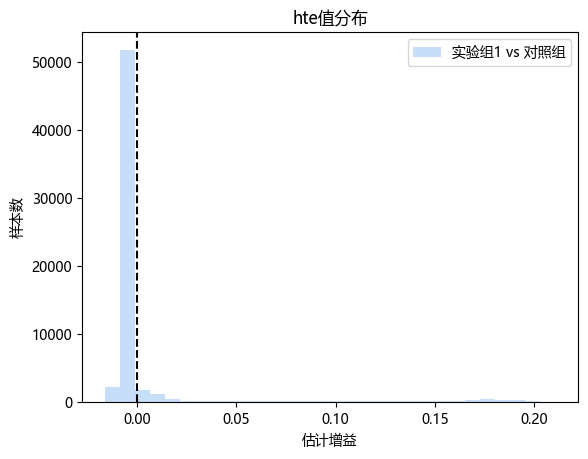

In [83]:
plt.hist(hte_1_vs_0,bins=30,alpha=0.6,label='实验组1 vs 对照组')
plt.axvline(0,color='k',linestyle='--')
plt.legend()
plt.title('hte值分布')
plt.xlabel('估计增益')
plt.ylabel('样本数')
plt.show()

如图所示，大部分用户在对照组的表现更好，但也有小部分用户在实验组1的表现好，还有极少一部分用户在实验组1表现特别好。

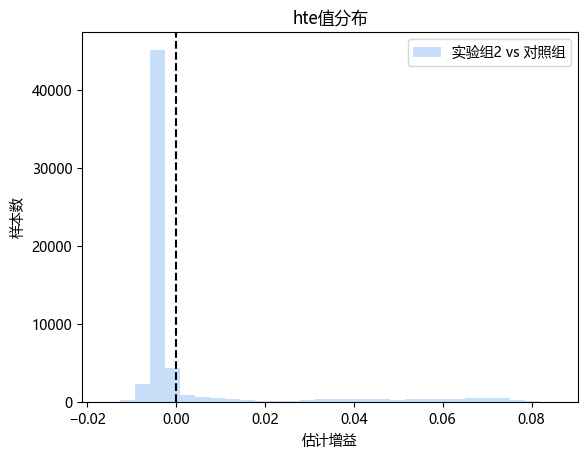

In [84]:
plt.hist(hte_2_vs_0,bins=30,alpha=0.6,label='实验组2 vs 对照组')
plt.axvline(0,color='k',linestyle='--')
plt.legend()
plt.title('hte值分布')
plt.xlabel('估计增益')
plt.ylabel('样本数')
plt.show()

如图所示，大部分用户在对照组的表现更好，但也有少部分用户在实验组1表现特别好，有的好一点有的非常多。

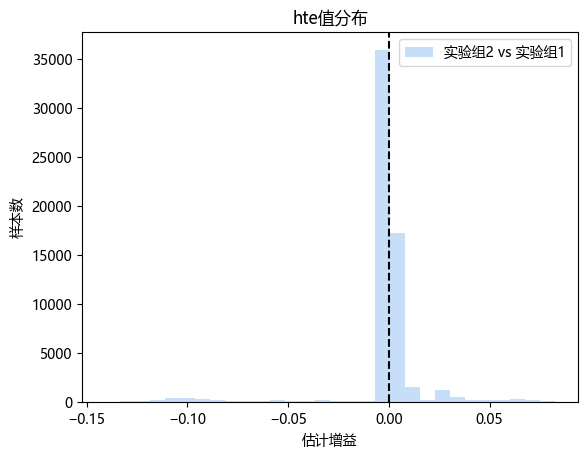

In [85]:
plt.hist(hte_2_vs_1,bins=30,alpha=0.6,label='实验组2 vs 实验组1')
plt.axvline(0,color='k',linestyle='--')
plt.legend()
plt.title('hte值分布')
plt.xlabel('估计增益')
plt.ylabel('样本数')
plt.show()

如图所示，有些用户在实验组1表现好，有些用户在实验组2表现好，在实验组1表现好的用户更多，但是在实验组2表现特别好的数量比实验组1多。

#### 特征重要性可视化

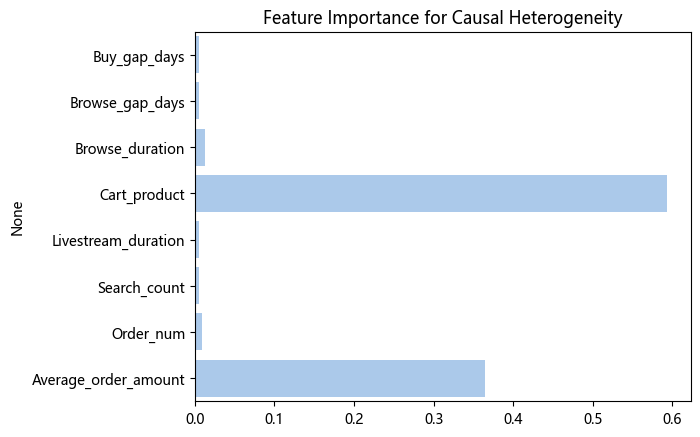

In [86]:
# 特征重要性
importances = cf.feature_importances_
feature_names = X_variable_test.columns
sns.barplot(x = importances,y = feature_names)
plt.title('Feature Importance for Causal Heterogeneity')
plt.show()

用 feature_importances_ 进行快速特征筛查，定位核心变量（如 cart_product, Average_order_amount）。

#### SHAP 解释图(展示了哪些特征对模型输出（如 CATE 或 HTE 的预测值）最有影响力，及其影响方向和程度。)

In [87]:
# shap_values 返回的是 个体化治疗效应（CATE）解释值
shap_outs = cf.shap_values(X_variable_test)
shap_outs

100%|===================| 119982/120000 [30:04<00:00]        

{'Y0': {'T0_1': .values =
  array([[-6.25948236e-04, -2.15640307e-04,  1.08732250e-02, ...,
          -3.55684647e-04,  4.35421840e-03,  6.36084287e-02],
         [ 8.53464340e-05,  4.94635687e-06, -9.79862796e-05, ...,
          -4.74297342e-05, -4.00899278e-04,  4.09254320e-03],
         [ 7.40278737e-05, -6.07938387e-05,  4.99194625e-04, ...,
           9.69090741e-06, -1.13779082e-04, -1.75298966e-03],
         ...,
         [ 1.27210405e-04, -1.26661830e-04, -3.49939967e-04, ...,
          -3.88222599e-06,  5.01778525e-05, -1.91976798e-03],
         [ 4.62013727e-05, -4.78294006e-04, -2.62229495e-03, ...,
          -1.21225517e-04, -1.30985269e-03,  7.38538631e-03],
         [ 1.01124993e-04, -2.79230333e-05,  4.40653672e-04, ...,
           1.72403135e-06, -1.50682741e-04, -1.54846153e-03]])
  
  .base_values =
  array([-0.00025539, -0.00025539, -0.00025539, ..., -0.00025539,
         -0.00025539, -0.00025539])
  
  .data =
  array([[102.  ,  49.  , 155.  , ...,   0.  ,   8.  ,  

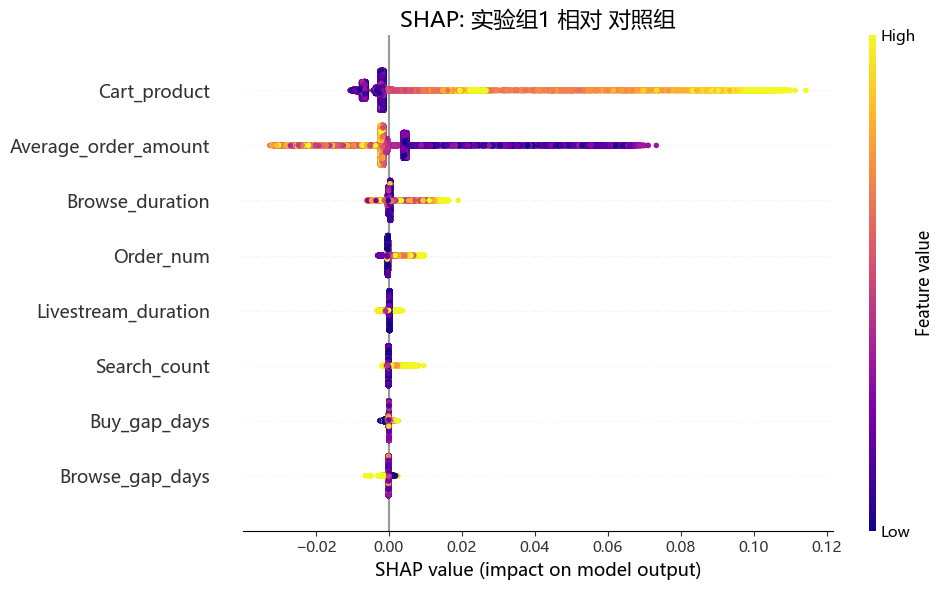

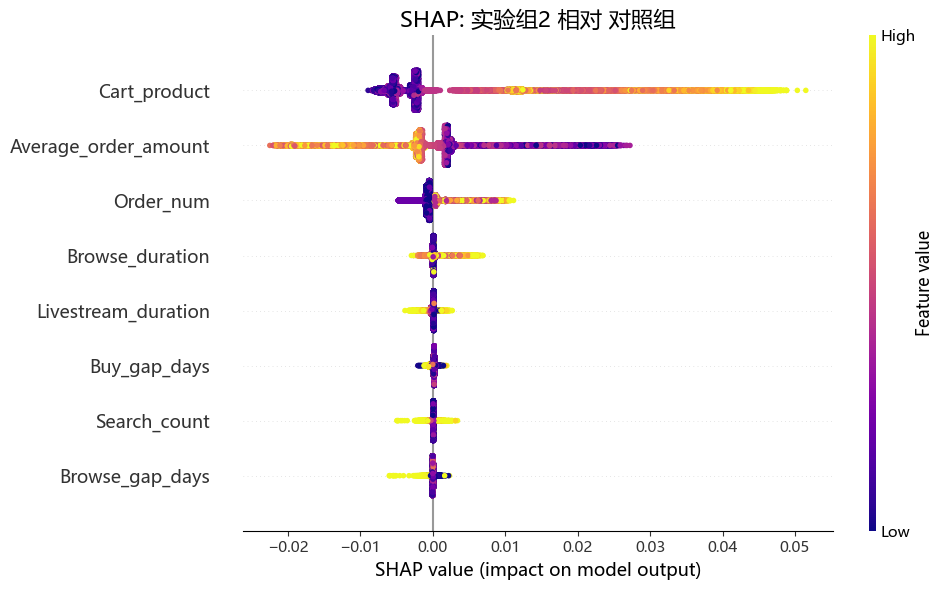

In [88]:
# 实验组1 vs 对照组
shap.summary_plot(shap_outs['Y0']['T0_1'],X_variable_test,cmap="plasma",plot_size=[10, 6],show=False)
plt.title('SHAP: 实验组1 相对 对照组',fontsize = 16)
plt.tight_layout()
plt.show()
# 实验组2 vs 对照组
shap.summary_plot(shap_outs['Y0']['T0_2'],X_variable_test,cmap="plasma",plot_size=[10, 6],show=False)
plt.title('SHAP: 实验组2 相对 对照组',fontsize = 16)
plt.tight_layout()
plt.show()

如图所示，实验组1和实验组2需要重点挖掘Cart_product即加购商品数高的用户以及Average_order_amount即平均订单金额少的用户，因为这类用户对于受策略影响大。

#### 为每个用户分配“最优策略”

In [89]:
# 合并成一个 DataFrame 方便操作
hte_merge = pd.DataFrame({'hte_1_vs_0':hte_1_vs_0,'hte_2_vs_0':hte_2_vs_0,'hte_2_vs_1':hte_2_vs_1})
# 默认最优策略为对照组（0）
hte_merge['best_strategy'] = 0
# 若满足实验组1更优的逻辑
condition_exp1 = (hte_merge['hte_1_vs_0'] > 0) & (hte_merge['hte_2_vs_1'] <= 0)
hte_merge.loc[condition_exp1,'best_strategy'] = 1
# 若满足实验组2更优的逻辑
condition_exp2 = (hte_merge['hte_2_vs_0'] > 0) & (hte_merge['hte_2_vs_1'] > 0)
hte_merge.loc[condition_exp2,'best_strategy'] = 2
hte_merge

,hte_1_vs_0,hte_2_vs_0,hte_2_vs_1,best_strategy
0,0.180055,0.069828,-0.110227,1
1,-0.002864,-0.003208,-0.000343,0
2,-0.002943,-0.003050,-0.000106,0
3,-0.004794,-0.004199,0.000595,0
4,-0.002782,-0.003137,-0.000355,0
...,...,...,...,...
59995,-0.003029,-0.002983,0.000046,0
59996,-0.003014,-0.003555,-0.000541,0
59997,-0.004440,-0.003554,0.000885,0
59998,0.002750,0.011183,0.008433,2


#### 决策树模型：提炼用户-策略规则

In [90]:
from sklearn.tree import DecisionTreeClassifier,export_text, plot_tree
#  best_strategy 是 0/1/2 的数组
Tree_model = DecisionTreeClassifier(max_depth=3,min_samples_leaf=200,random_state=0)
Tree_model.fit(X_variable_test,hte_merge['best_strategy'])

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,200
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [91]:
# 将决策树以文本形式输出
R = export_text(Tree_model,feature_names = list(X_variable_test.columns))
print(R)

|--- Cart_product <= 13.50
|   |--- Search_count <= 17.50
|   |   |--- Browse_duration <= 182.50
|   |   |   |--- class: 0
|   |   |--- Browse_duration >  182.50
|   |   |   |--- class: 0
|   |--- Search_count >  17.50
|   |   |--- class: 0
|--- Cart_product >  13.50
|   |--- Average_order_amount <= 18.13
|   |   |--- Cart_product <= 20.50
|   |   |   |--- class: 2
|   |   |--- Cart_product >  20.50
|   |   |   |--- class: 1
|   |--- Average_order_amount >  18.13
|   |   |--- Cart_product <= 21.50
|   |   |   |--- class: 0
|   |   |--- Cart_product >  21.50
|   |   |   |--- class: 0



SHAP 提供宏观层面的特征重要性，决策树提供微观分裂机制两者不冲突，而是互补。

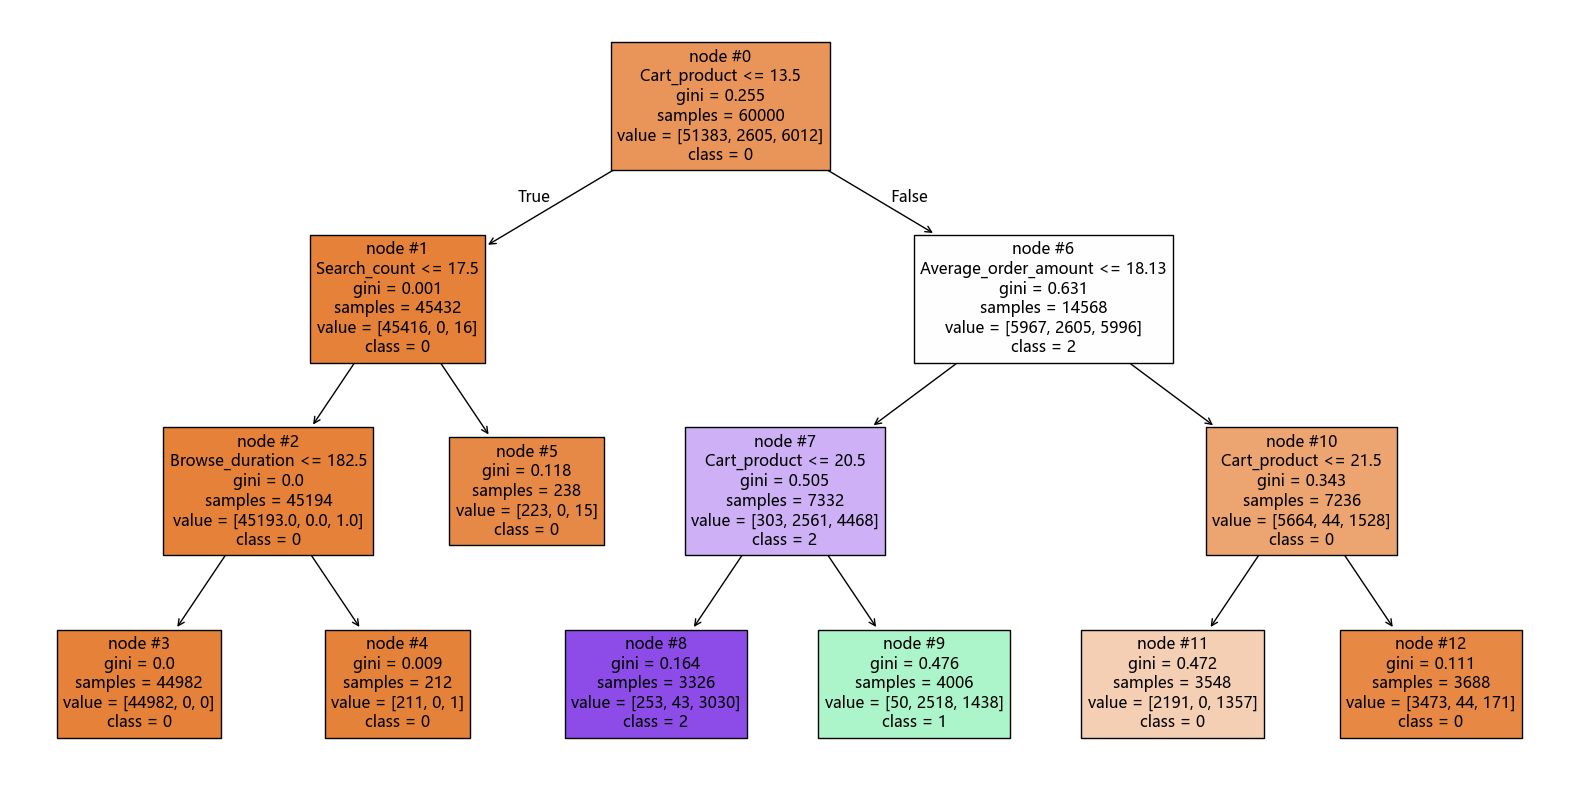

In [92]:
from sklearn import tree
# 将决策树以图形方式可视化
plt.figure(figsize=(20,10))
class_names = [str(c) for c in Tree_model.classes_]
tree.plot_tree(Tree_model,feature_names=list(X_variable_test.columns),class_names=class_names,filled=True,node_ids=True)
plt.show()

In [93]:
group_1

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group,T
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组,0
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组,0
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组,0
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组,0
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2,2
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2,2
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2,2
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2,2


In [94]:
# 添加Average_order_amount变量列
group_1['Average_order_amount'] = group_1['Order_amount'] / group_1['Order_num']
group_1['Average_order_amount'] = group_1['Average_order_amount'].round(2)

In [95]:
# 根据决策树划分规则，将用户划分到对应的组别
conditions = [(group_1['Cart_product'] <= 13.5) ,(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] <= 18.13) & (group_1['Cart_product'] <= 20.5),(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] <= 18.13) & (group_1['Cart_product'] > 20.5),(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] > 18.13) ]
choices = ['0','2','1','0']
group_1['最佳策略'] = np.select(conditions,choices,default='others')
group_1

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group,T,Average_order_amount,最佳策略
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组,0,9.00,0
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组,0,13.00,0
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组,0,11.00,0
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组,0,10.00,0
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组,0,10.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2,2,9.25,0
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2,2,14.00,0
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2,2,15.00,0
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2,2,14.33,0


In [96]:
# 按照最佳策略统计转化率
summary = group_1.groupby(['最佳策略','Group']).agg(total=('Is_repurchase','count'),reuse=('Is_repurchase','sum')).reset_index()
summary['rate'] = summary['reuse'] / summary['total']
summary

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,最佳策略,Group,total,reuse,rate
0,0,实验组1,87744,2073,0.023626
1,0,实验组2,87738,2049,0.023354
2,0,对照组,87800,2474,0.028178
3,1,实验组1,6653,990,0.148805
4,1,实验组2,6566,740,0.112702
5,1,对照组,6641,330,0.049691
6,2,实验组1,5603,206,0.036766
7,2,实验组2,5696,416,0.073034
8,2,对照组,5559,192,0.034539


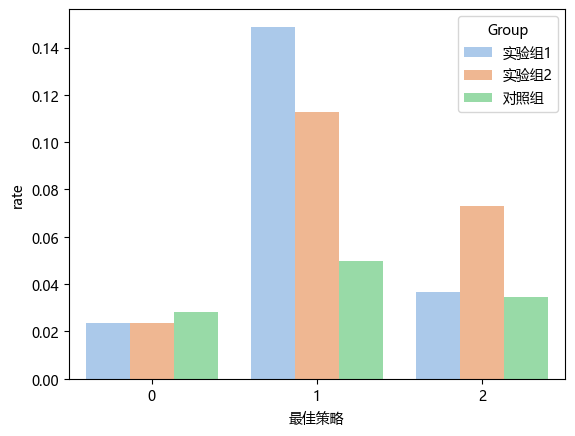

In [97]:
# 可视化rate的人群转化率
sns.barplot(data = summary,x='最佳策略',y='rate',hue='Group')
plt.show()

### 假设检验

进行假设检验，比较各个用户类别（根据"Cart_product加购商品数"和“Average_order_amount平均订单金额”（Order_amount：订单金额 / Order_num：订单数）这两个最重要的特征将用户分为最佳策略为0、1、2的3类用户）中在不同实验组（对照组、实验组1、实验组2）的使用召回礼券差异。由于拥有超过300,000个样本，并且可以估计方差，适合使用卡方检验（Chi-Square Test）来评估不同组之间的转化率差异是否显著。

In [98]:
user_level = group_1['最佳策略'].unique()
for level in user_level:
    # 筛选当前用户类别的数据
    subset = group_1[group_1['最佳策略'] == level]
    # 构建列联表：行是实验组，列是是否添加企微（0或1）
    contingency_table_3 = pd.crosstab(subset['Group'],subset['Is_repurchase'])
    # 检查列联表的形状，确保有足够的数据进行检验
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print (f'用户类别：{level}的数据不足，无法进行卡方检验。')
        continue
    # 执行卡方检验
    chi2,p,dof,expected = chi2_contingency(contingency_table_3)
    #输出结果
    print (f'用户类别：最佳策略{level}')
    print ('列联表：')
    print (contingency_table_3)
    print (f'卡方统计量：{chi2:.4f},自由度：{dof},p值：{p:.4f}')
    alpha = 0.05
    if p < alpha: 
        print("结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)")
    else:
        print("结论：接受原假设，三组转化率在使用召回礼券率方面不存在显著差异(p<0,05)")

用户类别：最佳策略0
列联表：
Is_repurchase      0     1
Group                     
实验组1           85671  2073
实验组2           85689  2049
对照组            85326  2474
卡方统计量：52.7899,自由度：2,p值：0.0000
结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)
用户类别：最佳策略2
列联表：
Is_repurchase     0    1
Group                   
实验组1           5397  206
实验组2           5280  416
对照组            5367  192
卡方统计量：114.9555,自由度：2,p值：0.0000
结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)
用户类别：最佳策略1
列联表：
Is_repurchase     0    1
Group                   
实验组1           5663  990
实验组2           5826  740
对照组            6311  330
卡方统计量：359.6840,自由度：2,p值：0.0000
结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)


根据以上卡方检验后的数据得出结论：三个实验即（召回礼券的有效期12小时、4小时、2小时）在不同的用户类别在使用召回礼券率整体存在显著差异。

最终结论：有效期缩短为4小时对最佳策略为1类的用户即 Cart_product加购商品数 > 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 有明显提升效果从照组的 4.96% 提升到 14.88%。  
  
有效期缩短为2小时对最佳策略为2类的用户即 13.5 < Cart_product加购商品数 <= 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 有明显提升效果从照组的 3.45% 提升到 7.30%.

### 基于树模型的uplift model（基即 Modeling uplift directly），判断出哪些特征能够区分出受策略影响的用户

In [99]:
from causalml.inference.tree import UpliftRandomForestClassifier

Failed to import duecredit due to No module named 'duecredit'


In [100]:
# 转换 treatment 列的数据类型
T_variable_train = T_variable_train.astype(str)

In [113]:
# 用 Uplift Random Forest 训练模型
uplift = UpliftRandomForestClassifier(control_name = '0',n_estimators=500,max_depth=10,min_samples_leaf=50,min_samples_treatment=10,evaluationFunction='KL',random_state=0)
uplift.fit(X_variable_train.values,treatment = T_variable_train.values,y = Y_variable_train.values)

In [114]:
# 落模型预测：输出每个样本各 treatment 的预测概率、uplift 分数
df_pred = uplift.predict(X_variable_test,full_output=True)
df_pred

,0,1,2,recommended_treatment,delta_1,delta_2,max_delta
0,0.051856,0.244247,0.131933,1,0.192390,0.080077,0.192390
1,0.019823,0.017455,0.016319,0,-0.002367,-0.003504,-0.002367
2,0.021476,0.017655,0.018287,0,-0.003821,-0.003189,-0.003189
3,0.078083,0.050274,0.048594,0,-0.027809,-0.029489,-0.027809
4,0.018177,0.016689,0.014970,0,-0.001489,-0.003208,-0.001489
...,...,...,...,...,...,...,...
59995,0.021784,0.019425,0.020132,0,-0.002359,-0.001652,-0.001652
59996,0.021141,0.017080,0.015866,0,-0.004061,-0.005275,-0.004061
59997,0.029213,0.023176,0.024643,0,-0.006037,-0.004570,-0.004570
59998,0.041584,0.035391,0.060551,2,-0.006193,0.018967,0.018967


In [115]:
# 提取个体 uplift（相对 control 组）：
u4h = df_pred['delta_1']
u2h = df_pred['delta_2']

In [116]:
# 绘制累积增益曲线 & AUUC
from sklift.metrics import uplift_curve,uplift_auc_score

In [117]:
# 计算 4h vs 12h 路径
# 一对数组 (x, y)，用于绘制 uplift 曲线：
# x：样本索引或累计样本数（按 uplift 降序排序）y：对应 x 点的累计 uplift 值（处理组响应率 − 对照组响应率，再乘以样本数量）
x4,y4 = uplift_curve(Y_variable_test,u4h,treatment=(T_variable_test==1))
# 返回值：一个 float，表示 归一化后的 AUUC（Area Under the Uplift Curve） 它将实际 uplift 曲线与理论最优曲线之间的面积作比，结果在 [0,1] 区间内
auc4 = uplift_auc_score(Y_variable_test,u4h,treatment=(T_variable_test==1))
# 计算 2h vs 12h 路径
x2,y2 = uplift_curve(Y_variable_test,u2h,treatment=(T_variable_test==2))
auc2 = uplift_auc_score(Y_variable_test,u2h,treatment=(T_variable_test==2))

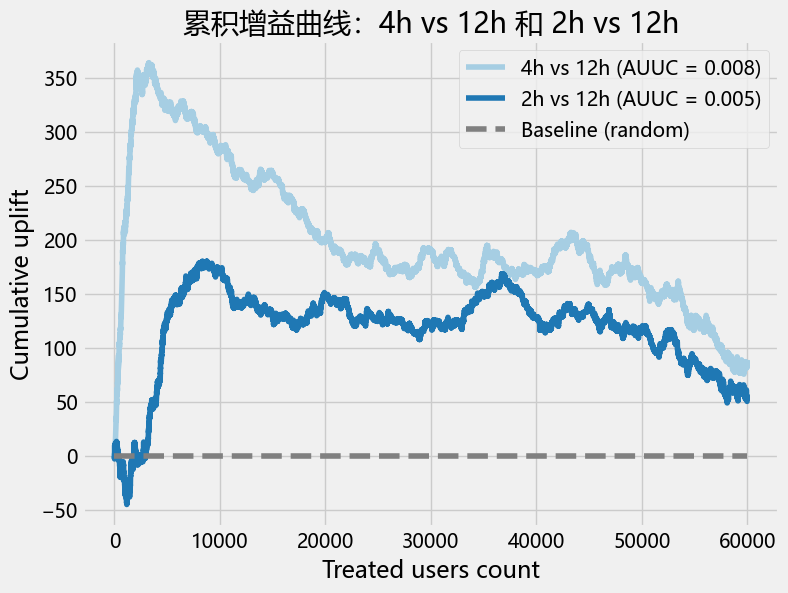

In [118]:
# 绘图
plt.figure(figsize=(8,6))
plt.plot(x4,y4,label=f'4h vs 12h (AUUC = {auc4:.3f})')
plt.plot(x2,y2,label=f'2h vs 12h (AUUC = {auc2:.3f})')
plt.plot([0, x2[-1]], [0, 0], '--', color='grey', label='Baseline (random)')
plt.xlabel('Treated users count')
plt.ylabel('Cumulative uplift')
plt.title('累积增益曲线：4h vs 12h 和 2h vs 12h')
plt.legend()
plt.show()

结论：1、4h策略更有效：它在前期“投放”时可获得更高的用户转化增量。2、边际效益递减：随着覆盖更多用户，新增用户贡献的uplift会下降，甚至接近0。3、对比效果两根蓝色的实线总体在灰线上，证明模型比随机投放好；浅蓝始终高于深蓝说明4h策略比2h表现更强。4、建议覆盖预测uplift更高的用户（浅蓝前期拐点），以最大化转化提升。

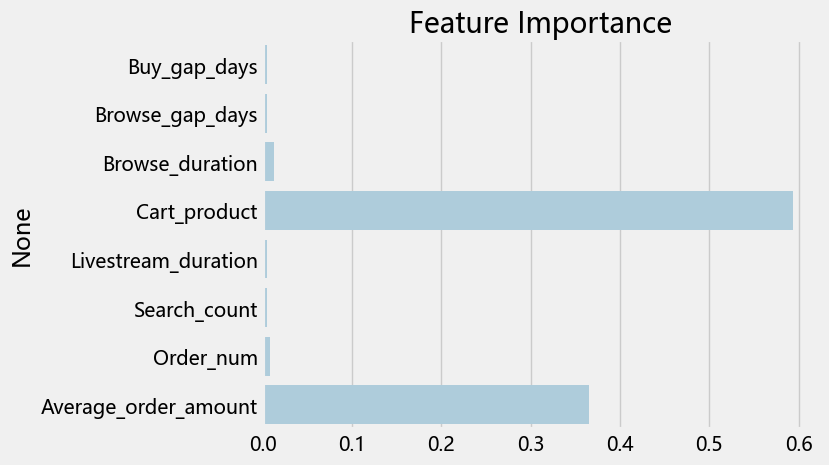

In [119]:
# 特征重要性
uplift_importances = uplift.feature_importances_
feature_names = X_variable_test.columns
sns.barplot(x = importances,y = feature_names)
plt.title('Feature Importance')
plt.show()

#### 决策树模型：提炼用户-策略规则

In [123]:
df_pred

,0,1,2,recommended_treatment,delta_1,delta_2,max_delta
0,0.051856,0.244247,0.131933,1,0.192390,0.080077,0.192390
1,0.019823,0.017455,0.016319,0,-0.002367,-0.003504,-0.002367
2,0.021476,0.017655,0.018287,0,-0.003821,-0.003189,-0.003189
3,0.078083,0.050274,0.048594,0,-0.027809,-0.029489,-0.027809
4,0.018177,0.016689,0.014970,0,-0.001489,-0.003208,-0.001489
...,...,...,...,...,...,...,...
59995,0.021784,0.019425,0.020132,0,-0.002359,-0.001652,-0.001652
59996,0.021141,0.017080,0.015866,0,-0.004061,-0.005275,-0.004061
59997,0.029213,0.023176,0.024643,0,-0.006037,-0.004570,-0.004570
59998,0.041584,0.035391,0.060551,2,-0.006193,0.018967,0.018967


In [129]:
Tree_model_2 = DecisionTreeClassifier(max_depth =3,min_samples_leaf=200,random_state=0)

In [130]:
# 这次树模型只放入了最重要的2个特征
Tree_model_2.fit(X_variable_test[['Cart_product','Average_order_amount']],df_pred['recommended_treatment'])

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,200
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [132]:
#将决策树以文本形式输出
R_2 = export_text(Tree_model_2,feature_names = ['Cart_product','Average_order_amount'])
print(R_2)

|--- Cart_product <= 13.50
|   |--- Average_order_amount <= 27.77
|   |   |--- Cart_product <= 0.50
|   |   |   |--- class: 0
|   |   |--- Cart_product >  0.50
|   |   |   |--- class: 0
|   |--- Average_order_amount >  27.77
|   |   |--- Cart_product <= 1.50
|   |   |   |--- class: 2
|   |   |--- Cart_product >  1.50
|   |   |   |--- class: 1
|--- Cart_product >  13.50
|   |--- Average_order_amount <= 17.89
|   |   |--- Average_order_amount <= 14.95
|   |   |   |--- class: 1
|   |   |--- Average_order_amount >  14.95
|   |   |   |--- class: 2
|   |--- Average_order_amount >  17.89
|   |   |--- Cart_product <= 15.50
|   |   |   |--- class: 2
|   |   |--- Cart_product >  15.50
|   |   |   |--- class: 0



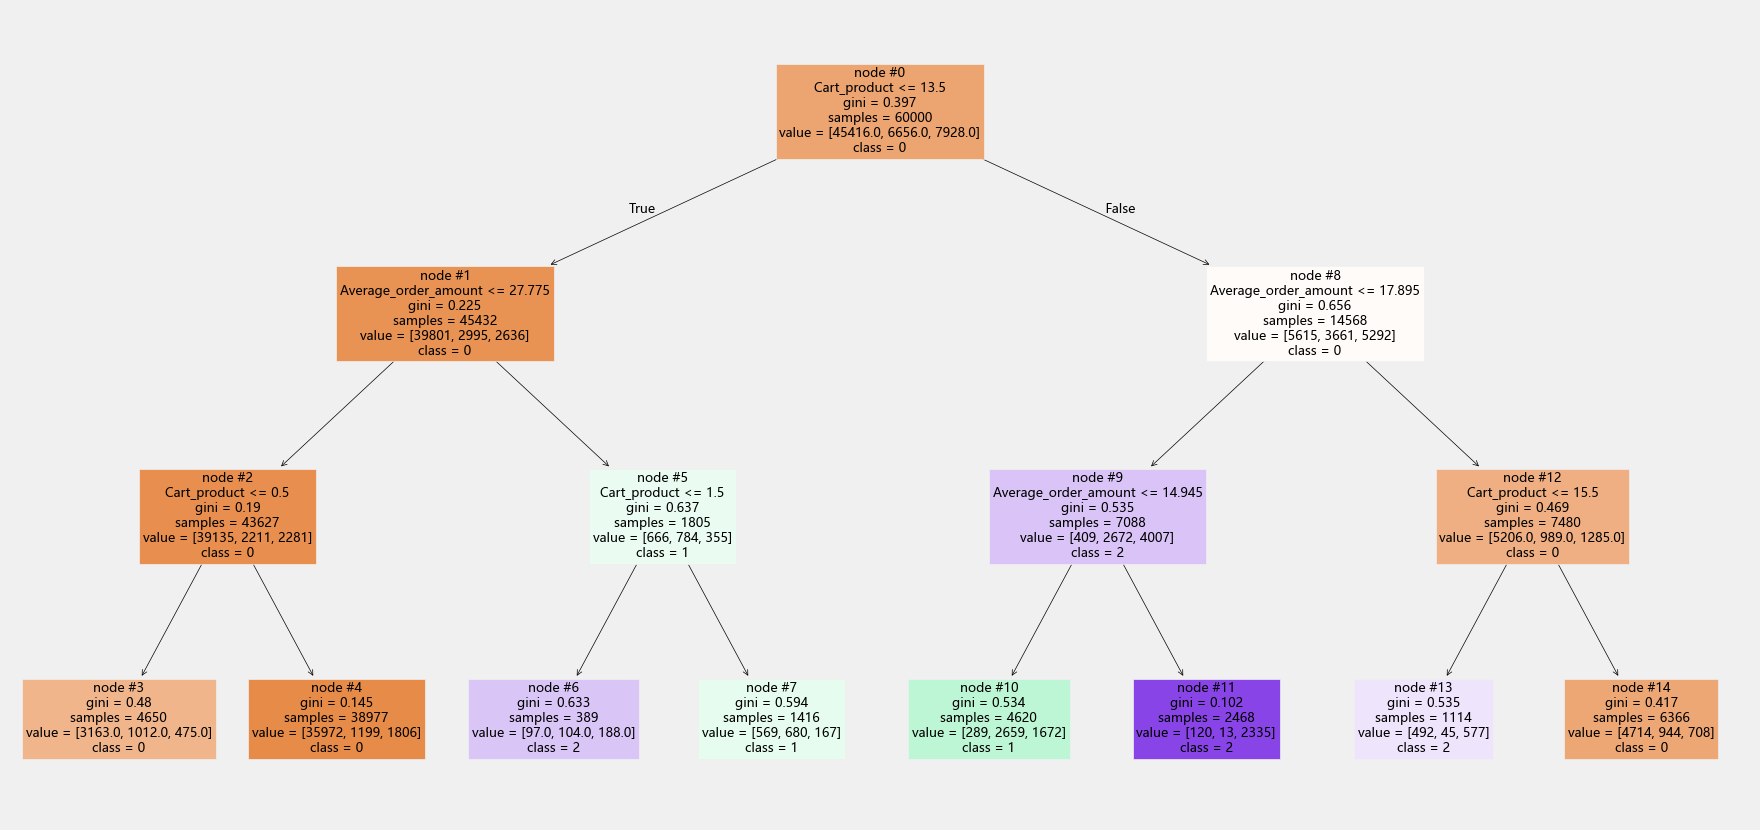

In [134]:
#将决策树以图形方式可视化
plt.figure(figsize=(20,10))
class_names = [str(c) for c in Tree_model_2.classes_]
tree.plot_tree(Tree_model_2,feature_names=['Cart_product','Average_order_amount'],class_names=class_names,filled=True,node_ids=True)
plt.show()

In [135]:
group_1

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group,T,Average_order_amount,最佳策略
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组,0,9.00,0
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组,0,13.00,0
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组,0,11.00,0
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组,0,10.00,0
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组,0,10.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2,2,9.25,0
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2,2,14.00,0
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2,2,15.00,0
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2,2,14.33,0


In [136]:
#根据决策树划分规则，将用户划分到对应的组别
conditions = [(group_1['Cart_product'] <= 13.5) & (group_1['Average_order_amount'] <= 27.775) ,(group_1['Cart_product'] <= 13.5) & (group_1['Average_order_amount'] > 27.775) & (group_1['Cart_product'] <= 1.5),(group_1['Cart_product'] <= 13.5) & (group_1['Average_order_amount'] > 27.775) & (group_1['Cart_product'] > 1.5),(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] <= 17.895) & (group_1['Average_order_amount'] <= 14.945),(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] <= 17.895) & (group_1['Average_order_amount'] > 14.945),(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] > 17.895) & (group_1['Cart_product'] <= 15.5),(group_1['Cart_product'] > 13.5) & (group_1['Average_order_amount'] > 17.895) & (group_1['Cart_product'] > 15.5)]
choices = ['0','2','1','1','2','2','0']
group_1['recommended_treatment'] = np.select(conditions,choices,default='others')
group_1

,User_id,Order_num,Coupon_order,Order_amount,Browse_product,Browse_duration,Cart_product,Livestream_duration,Search_count,Buy_gap_days,Browse_gap_days,Coupon_time,Is_repurchase,Group,T,Average_order_amount,最佳策略,recommended_treatment
0,890765312,1,1,9,4,11,0,5,1,78,16,7-12点,0,对照组,0,9.00,0,0
1,423100416,1,1,13,3,9,1,0,1,52,27,7-12点,0,对照组,0,13.00,0,0
2,204996613,1,1,11,6,16,1,2,0,37,22,7-12点,0,对照组,0,11.00,0,0
3,198705158,1,1,10,1,3,0,4,1,56,41,7-12点,0,对照组,0,10.00,0,0
4,380108807,1,1,10,2,10,2,5,1,153,22,7-12点,0,对照组,0,10.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,523239411,4,4,37,30,60,4,12,0,35,10,7-12点,1,实验组2,2,9.25,0,0
299996,437256182,2,2,28,12,48,6,20,0,70,35,7-12点,0,实验组2,2,14.00,0,0
299997,848822264,1,1,15,5,28,2,13,2,68,18,7-12点,0,实验组2,2,15.00,0,0
299998,299892729,3,2,43,8,16,4,6,3,87,23,7-12点,0,实验组2,2,14.33,0,0


In [139]:
#按照recommended_treatment统计转化率
summary_2 = group_1.groupby(['recommended_treatment','Group']).agg(total=('Is_repurchase','count'),reuse=('Is_repurchase','sum')).reset_index()
summary_2['rate'] = summary_2['reuse'] / summary_2['total']
summary_2

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,recommended_treatment,Group,total,reuse,rate
0,0,实验组1,83051,1922,0.023142
1,0,实验组2,83108,1908,0.022958
2,0,对照组,83158,2324,0.027947
3,1,实验组1,10242,1103,0.107694
4,1,实验组2,10236,808,0.078937
5,1,对照组,10152,392,0.038613
6,2,实验组1,6707,244,0.036380
7,2,实验组2,6656,489,0.073468
8,2,对照组,6690,280,0.041854


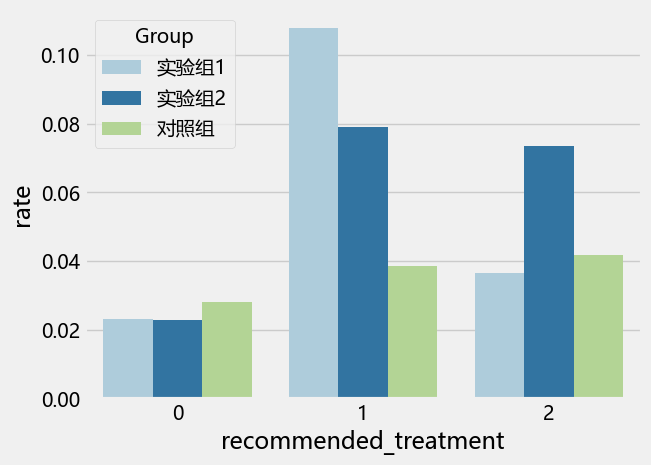

In [140]:
#可视化rate的人群转化率
sns.barplot(data = summary_2,x='recommended_treatment',y='rate',hue='Group')
plt.show()

### 假设检验

进行假设检验，比较各个用户类别（根据"Cart_product加购商品数"和“Average_order_amount平均订单金额”（Order_amount：订单金额 / Order_num：订单数）这两个最重要的特征将用户分为recommended_treatment为0、1、2的3类用户）中在不同实验组（对照组、实验组1、实验组2）的使用召回礼券差异。由于拥有超过300,000个样本，并且可以估计方差，适合使用卡方检验（Chi-Square Test）来评估不同组之间的转化率差异是否显著。

In [142]:
user_level_2 = group_1['recommended_treatment'].unique()
for level in user_level_2:
    # 筛选当前用户类别的数据
    subset = group_1[group_1['recommended_treatment'] == level]
    # 构建列联表：行是实验组，列是是否添加企微（0或1）
    contingency_table_4 = pd.crosstab(subset['Group'],subset['Is_repurchase'])
    # 检查列联表的形状，确保有足够的数据进行检验
    if contingency_table_4.shape[0] < 2 or contingency_table_4.shape[1] < 2:
        print (f'用户类别：{level}的数据不足，无法进行卡方检验。')
        continue
    # 执行卡方检验
    chi2,p,dof,expected = chi2_contingency(contingency_table_4)
    #输出结果
    print (f'用户类别：recommended_treatment{level}')
    print ('列联表：')
    print (contingency_table_4)
    print (f'卡方统计量：{chi2:.4f},自由度：{dof},p值：{p:.4f}')
    alpha = 0.05
    if p < alpha:
        print("结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)")
    else:
        print("结论：接受原假设，三组转化率在使用召回礼券率方面不存在显著差异(p<0,05)")

用户类别：recommended_treatment0
列联表：
Is_repurchase      0     1
Group                     
实验组1           81129  1922
实验组2           81200  1908
对照组            80834  2324
卡方统计量：55.2552,自由度：2,p值：0.0000
结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)
用户类别：recommended_treatment2
列联表：
Is_repurchase     0    1
Group                   
实验组1           6463  244
实验组2           6167  489
对照组            6410  280
卡方统计量：111.5095,自由度：2,p值：0.0000
结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)
用户类别：recommended_treatment1
列联表：
Is_repurchase     0     1
Group                    
实验组1           9139  1103
实验组2           9428   808
对照组            9760   392
卡方统计量：353.0107,自由度：2,p值：0.0000
结论：拒绝原假设，三组转化率在使用召回礼券率方面存在显著差异(p<0,05)


根据以上卡方检验后的数据得出结论：三个实验即（召回礼券的有效期12小时、4小时、2小时）在不同的用户类别在使用召回礼券率整体存在显著差异。

最终结论：有效期缩短为4小时对recommended_treatment为1类的用户即 1.5 < Cart_product加购商品数 <= 13.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) > 27.775 / Cart_product加购商品数 > 13.5 且 Average_order_amount平均订单金额 <= 14.945有明显提升效果从对照组的 3.86% 提升到 10.77%。

有效期缩短为2小时对recommended_treatment为2类的用户即 Cart_product加购商品数 <= 1.5 且 Average_order_amount平均订单金额 > 27.775 / Cart_product加购商品数 > 13.5 且 14.945 < Average_order_amount平均订单金额 <= 17.895 / 13.5 < Cart_product加购商品数 <= 15.5 且 Average_order_amount平均订单金额 > 17.895有明显提升效果从对照组的 4.18% 提升到 7.34%。

就最后召回礼券利用率结果而言，causal forest(因果森林)模型效果表现更好即提升的转化率越高，所以我接下来采用因果森林的数据进行接下来的分析步骤。

### 设计AB实验（根据因果森林模型筛选的受策略影响大重要特征，再用决策树进行特征划分）

为了验证分析优惠券有效期调整是否有效，以及对不同消费特征用户设置不同的召回礼券有效期能是否有效提升召回礼券的使用率，设计2个A/B实验，分别针对，最佳策略为1类的用户即 Cart_product加购商品数 > 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 ，最佳策略为2类的用户即 13.5 < Cart_product加购商品数 <= 20.5 且 Average_order_amount平均订单金额 <= 18.13。

#### 针对最佳策略为1类的用户即 Cart_product加购商品数 > 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 的A/B实验

一、明确实验改动点,我们要保证AB测试的单一因素原则，即每一个实验的评估因素都是单一因素，实验改动点为召回礼券有效期时长。
对照组：召回礼券的有效期12小时
实验组1：召回礼券的有效期调整为4小时
实验组2：召回礼券的有效期调整为2小时
二、明确观测指标,在本次A/B实验中需要观察的指标为比率类指标:召回礼券使用率,即统计最佳策略为1类的用户在每个组的召回礼券使用率 = 最佳策略为2类用户的Is_repurchase(在每个组使用召回礼券)的数量/最佳策略为1类的用户在每个组的总人数
三、AB实验样本量计算
通过样本量计算公式N=δ2σ2​(Z1−​​+Z1−β​)2，设置显著性水平α=0.05,Z1-α/2=1.96 统计功效：β = 0.2,Z1-β = 0.84, 计算原始数据集中最佳策略为1类的用户的召回礼券使用率=4.96%（仅对照组），以及预期的召回礼券使用率14.88%得出δ =0.0992，根据原始数据算出来的转化率提升为大概约为10%，计算出所需样本量大于91个，在未来实验中每个组即对照组/实验组1/实验组2需要收集的用户数量不少91才满足需求。
四、AB实验流量分割
在当前A/B实验中，为确保实验结果有效性和可解释性，在‘流量分割’阶段采用分流分层模型，在将用户分配进A/B实验中，1、根据Cart_product加购商品数和Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数)将用户分为了最佳策略为0，1，2三类用户，在每个层内随机分流进入各实验组。2、在每个层内随机分组。3、检查分组是否均衡。
五、实验周期计算
实验时间必须超过最小实验周期，AB实验才算有效，目前未知每日回归人数即特征符合最佳策略为1类的用户每日领取召回礼券的人数，假设每天有5000回归用户，访问预估有1500人落在最佳策略为1类的用户上，大概需要不到1天。同时需要避免节假日或促销干扰，避免该时段 还需要考虑周末效应即工作日和周末的用户可能存在不同购买习惯，预留1-2天缓冲，留时间跑灰度验证。实验尽量实施7-14天。
六、AB测试上线
在正式上线实验前，会用一小部分流量看一段时间的灰度实验，为了验证这个改动不会造成特别极端的影响。灰度之后就正式发版，等实验周期结束，对实验结果进行显著性检验。同时要进行数据埋点的安排。
七、效果评估验证
商业上的验证：通过前面确认的核心指标以及相关指标在对照组和实验组之间的对比，来综合判定AB实验测试效果。
统计上的验证：通过统计学上的假设检验中的双尾检验来验证AB测试是否具有统计学意义上的显著有效，避免遗漏判断策略可能带来的负面影响例如转化率下降。

#### 针对最佳策略为2类的用户即 13.5 < Cart_product加购商品数 <= 20.5 且 Average_order_amount平均订单金额 <= 18.13的A/B实验

一、明确实验改动点,我们要保证AB测试的单一因素原则，即每一个实验的评估因素都是单一因素，实验改动点为召回礼券有效期时长。
对照组：召回礼券的有效期12小时
实验组1：召回礼券的有效期调整为4小时
实验组2：召回礼券的有效期调整为2小时
二、明确观测指标,在本次A/B实验中需要观察的指标为比率类指标:召回礼券使用率,即统计最佳策略为2类的用户在每个组的召回礼券使用率 = 最佳策略为2类用户的Is_repurchase(在每个组使用召回礼券)的数量/最佳策略为2类的用户在每个组的总人数
三、AB实验样本量计算
通过样本量计算公式N=δ2σ2​(Z1−​​+Z1−β​)2，设置显著性水平α=0.05,Z1-α/2=1.96 统计功效：β = 0.2,Z1-β = 0.84, 计算原始数据集中最佳策略为2类的用户的召回礼券使用率=3.45%（仅对照组），以及预期的召回礼券使用率7.30%得出δ =0.0385，根据原始数据算出来的转化率提升为大概约为4%，计算出所需样本量大于375个，在未来实验中每个组即对照组/实验组1/实验组2需要收集的用户数量不少375才满足需求。
四、AB实验流量分割
在当前A/B实验中，为确保实验结果有效性和可解释性，在‘流量分割’阶段采用分流分层模型，在将用户分配进A/B实验中，1、根据Cart_product加购商品数和Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数)将用户分为了最佳策略为0，1，2三类用户，在每个层内随机分流进入各实验组。2、在每个层内随机分组。3、检查分组是否均衡。
五、实验周期计算
实验时间必须超过最小实验周期，AB实验才算有效，目前未知每日回归人数即特征符合最佳策略为2类的用户每日领取召回礼券的人数，假设每天有5000回归用户，访问预估有1500人落在最佳策略为2类的用户上，大概需要不到1天。同时需要避免节假日或促销干扰，避免该时段 还需要考虑周末效应即工作日和周末的用户可能存在不同购买习惯，预留1-2天缓冲，留时间跑灰度验证。实验尽量实施7-14天。
六、AB测试上线
在正式上线实验前，会用一小部分流量看一段时间的灰度实验，为了验证这个改动不会造成特别极端的影响。灰度之后就正式发版，等实验周期结束，对实验结果进行显著性检验。同时要进行数据埋点的安排。
七、效果评估验证
商业上的验证：通过前面确认的核心指标以及相关指标在对照组和实验组之间的对比，来综合判定AB实验测试效果。
统计上的验证：通过统计学上的假设检验中的双尾检验来验证AB测试是否具有统计学意义上的显著有效，避免遗漏判断策略可能带来的负面影响例如转化率下降。

## 项目总结

### 一、项目背景

抖音商城将近 30 天未在商城提交下单过订单的用户浏览商城视为用户回归，当用户回归时，平台会发放平台召回礼券，召回礼券的有效期是12小时。
回归礼券在用户30天未在商城提交下单过订单后，首次浏览商城时弹窗显示，弹窗显示召回礼券的金额、有效期时间倒计时，弹窗下方有“领取”的按钮，弹窗右上方有较小的关闭窗口按钮，弹窗显示后即自动领券，无论用户是否点击“领取”按钮，优惠券都自动到账。

### 二、召回礼券的使用率需要提升，作为数据分析师需分析现有数据，找寻提升点。（暂不考虑调整召回礼券的金额） 

2-1 数据准备   
User_id：用户ID  
Coupon_time：领取回归礼券的时间段（ 0-6点 / 7-12点 / 13-18点 / 19-24点）  

（以下为领取召回券前的行为数据）  
Buy_gap_days：领取召回券与前一次下单间隔天数  
Browse_gap_days：领取召回券与前一次浏览商城间隔天数  
Browse_duration：浏览商城时长（分钟）  
Browse_product：浏览商品数量  
Cart_product：加购商品数  
Livestream_duration：观看商城直播时长  
Search_count：商城搜索次数  
Order_num：订单数  
Order_amount：订单金额  
Coupon_order：使用优惠券的订单数  
 
Is_repurchase：是否使用召回礼券  

2-2 数据的读取与评估清理  
将以上数据导入jupyter notebook将数据格式解析成DataFrame。
对于导入的数据从结构和内容，即整齐度和干净度进行评估清洗，使得数据从结构上符合“每个变量为一列，每个观察值为一行，每种类型的观察单位为一个表格”这三个标准，从内容上需要处理丢失数据、重复数据、和无效数据。经过处理后发现该数据集非常的整齐、干净。仅对User_id的数据类型转换成字符串，Coupon_time为分类数据，转换成了category数据类型。

2-3 根据Coupon_time领取回归礼券的时间段对比使用率
在数据集的所有字段中，Counpon_time是唯一的分类变量，所以我们想根据Coupon_time领取回归礼券的时间，来探索分析一下领取时间是否影响召回礼券的使用率，找出使用率最低的时间段，采取一下优化措施。在统计了4个时间段的领取召回礼券的总人数和使用召回礼券的总人数计算出各时间段的召回礼券使用率，发现7-12点的召回礼券使用率最低。针对这个最低的时间段给运营组的同事提出了一些建设性的优化意见，如缩短优惠券有效期，优化优惠券弹窗显示的内容，提高弹窗提醒频率等最终方案由运营同事决定。

2-4 尝试对原数据集建立分类模型，筛选出预测使用率的最重要的特征
首先建立的是逻辑回归模型，将数据集进行预处理，将Coupon_time这样的分类变量映射成0，1，2，3，对于除了User_id这种唯一标识变量外的数值变量进行了标准化。与此同时，对于多类数值特征用corr和vif方法去检测它们的相关性，将与其他特征有严重共线性的Order_num和Coupon_order特征删除。之后总体对比了一下总体数据集的使用召回礼券数量，发现不使用数量是使用数量的接近30倍，数据集不均衡，所以采用了过采样的smote方法解读样本数量不平衡问题。然后建立逻辑回归模型训练和测试数据绘制混淆矩阵评估模型效果，模型效果并不理想模型对于Y=1的用户预测的精度、recall、f1-score值均很低，之后对模型进行了调优，也测试了不同阈值的模型表现，最终效果也是一般，最后按照相同的流程测试了随机森林、XGboost这几种分类模型，还是不理想，分析原因大概率是应该少数类（Y=0）样本特征信息不足的原因，所以在接下来暂不进行重要特征特性提取等后续的分析动作，先根据上述发现7-12点这个时间段转化率低进行提出进一步优化措施。

### 三、作为数据分析师需分析召回礼券的有效期缩短是否能提高转化率？有效期缩短对哪种特征的用户刺激转化的效果最大？

3-1 数据准备
分析数据发现，领取回归礼券时间在上午的7-12点的用户，领券后的下单转化率低于其他时段的下单转化率。运营同事考虑缩短上午7-12点发放的召回礼券有效期，设计了下面的AB实验。
对照组：召回礼券的有效期12小时
实验组1：召回礼券的有效期调整为4小时
实验组2：召回礼券的有效期调整为2小时
AB实验数据
User_id：用户ID
Group：分组
Coupon_time：领取回归礼券的时间段（7-12点）
 
（以下为领取召回券前的行为数据）
Buy_gap_days：领取召回券与前一次下单间隔天数
Browse_gap_days：领取召回券与前一次浏览商城间隔天数
Browse_duration：浏览商城时长（分钟）
Browse_product：浏览商品数量
Cart_product：加购商品数
Livestream_duration：观看商城直播时长
Search_count：商城搜索次数
Order_num：订单数
Order_amount：订单金额
Coupon_order：使用优惠券的订单数
 
Is_repurchase：是否使用召回礼券
作为数据分析师需分析召回礼券的有效期缩短是否能提高转化率？有效期缩短对哪种特征的用户刺激转化的效果最大？

3-1 验证召回礼券的有效期缩短是否能提高转化率
前面同样的对于运营同事提供的新数据集进行清洗、整理、评估等步骤，之后在干净的新数据集统计用户在不同实验组（即不同的召回礼券有效期12h,4h,2h）的召回礼券使用率，将最后的使用率差异进行了假设检验发现，有效期缩短的确在统计学意义上提高了使用率。

3-2 验证判断有效期缩短对哪种特征的用户刺激转化的效果最大
3-2-1 建立因果推断模型中因果森林，判断出哪些特征能够区分出受策略影响的用户
对于验证新策略实施对于用户使用率的提升表现，因果推断肯定是非常好的方式。首先同样是对数据进行预处理，将分类变量Group映射成0，1，2，然后将Is_repurchase是否使用召回礼券概变量设置为Y结果变量，将Group组别设置为处理变量T,剩下出了User_id的全部数值变量设置为X特征。虽然随机森林对多重共线性不敏感，但是会模糊因果洞察，相关特征的贡献会被平摊。所以在训练模型前检查变量相关性，将部分特征进行了组合得到如Average_order_amount(平均订单金额) ，删除部分特征如Coupon_order使用优惠券的订单数、Order_amount订单金额等。最后将处理好的X、Y、T变量进行训练集测试集切分、因果森林模型的训练和预测等流程预测出测试集每位用户的cate、hte、ate值，根据这些值绘制了分布图、shap解释图以及为每个用户分配最优策略等操作，结合模型的特重要性系数找到Cart_product即加购商品数高的用户以及Average_order_amount即平均订单金额少的用户，这类用户对于受策略影响大。之后提取重要的用户特征和最佳策略建立决策树模型，让模型自动帮我找出特征的划分值，然后可视化树模型，根据树模型划分规则将用户分为3类，统计3类用户在总数据集的3个group表现，计算不同特征人群在3个组的利用率表现，最后将利用率进行显著性检验得出结论有效期缩短为4小时对最佳策略为1类的用户即 Cart_product加购商品数 > 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 有明显提升效果从原来的 4.96% 提升到 14.88%，有效期缩短为2小时对最佳策略为2类的用户即 13.5 < Cart_product加购商品数 <= 20.5 且 Average_order_amount平均订单金额 <= 18.13 有明显提升效果从原来的 3.45% 提升到 7.30%。

3-2-2 建立因果推断模型中基于树模型uplift model，判断出哪些特征能够区分出受策略影响的用户
将上一步处理好的X，Y，T变量训练，预测uplift model得到测试集每个变量在每个组的利用率，计算实验1与对照之间的uplift值，实验组2与对照组之间uplift值，然后为每位用户推出最佳recommeded_treatment,同时根据每个组的每个个体的uplift值绘制累计增益曲线和auuc值得出总体结论4h策略更有效：它在前期“投放”时可获得更高的用户转化增量。同时也可视化了模型的feature importance 也发现Cart_product和Average_order_amount是其最重要的特征，同上的步骤将这两个最重要的特征和recommeded_treatment建立决策树模型，让模型自动划分特征以及可视化树模型，再将树模型得到的特征返回总数据集计算不同特征人群在3个组的利用率表现，最后将利用率进行显著性检验得出结论有效期缩短为4小时对recommended_treatment为1类的用户即 1.5 < Cart_product加购商品数 <= 13.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) > 27.775 / Cart_product加购商品数 > 13.5 且 Average_order_amount平均订单金额 <= 14.945有明显提升效果从对照组的 3.86% 提升到 10.77%。有效期缩短为2小时对recommended_treatment为2类的用户即 Cart_product加购商品数 <= 1.5 且 Average_order_amount平均订单金额 > 27.775 / Cart_product加购商品数 > 13.5 且 14.945 < Average_order_amount平均订单金额 <= 17.895 / 13.5 < Cart_product加购商品数 <= 15.5 且 Average_order_amount平均订单金额 > 17.895有明显提升效果从对照组的 4.18% 提升到 7.34%。
总结：就最后召回礼券利用率结果而言，causal forest(因果森林)模型效果表现更好即提升的转化率越高，所以我接下来采用因果森林的数据进行接下来的分析步骤。

### 设计A/B实验

4-1 根据因果森林模型筛选的受策略影响大重要特征，再用决策树进行特征划分的A/B实验
为了验证分析优惠券有效期调整是否有效，以及对不同消费特征用户设置不同的召回礼券有效期能是否有效提升召回礼券的使用率，设计2个A/B实验，分别针对，最佳策略为1类的用户即 Cart_product加购商品数 > 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 ，最佳策略为2类的用户即 13.5 < Cart_product加购商品数 <= 20.5 且 Average_order_amount平均订单金额 <= 18.13。

4-2 针对最佳策略为1类的用户即 Cart_product加购商品数 > 20.5 且 Average_order_amount平均订单金额(Order_amount：订单金额 / Order_num：订单数) <= 18.13 的A/B实验
实验目的：为了分析优惠券有效期调整是否有效，以及对不同消费特征用户设置不同的召回礼券有效期能是否有效提升召回礼券的使用率。
实验策略动作：对照组的用户回归时，平台会发放平台召回礼券，召回礼券的有效期是12小时，实验组1的用户回归时，平台会发放平台召回礼券，召回礼券的有效期是4小时以及实验组2的用户回归时，平台会发放平台召回礼券，召回礼券的有效期是2小时
分流单位：以用户ID为单位，保证同一用户仅在对照组、实验组1、实验组2。
核心指标：召回礼券使用率
最小样本量：91
如何分组：将用户随机分入对照组、实验组1或实验组2。
对照组：召回礼券的有效期12小时
实验组1：召回礼券的有效期调整为4小时
实验组2：召回礼券的有效期调整为2小时

4-3 针对最佳策略为2类的用户即 13.5 < Cart_product加购商品数 <= 20.5 且 Average_order_amount平均订单金额 <= 18.13的A/B实验
实验目的：为了分析优惠券有效期调整是否有效，以及对不同消费特征用户设置不同的召回礼券有效期能是否有效提升召回礼券的使用率。
实验策略动作：对照组的用户回归时，平台会发放平台召回礼券，召回礼券的有效期是12小时，实验组1的用户回归时，平台会发放平台召回礼券，召回礼券的有效期是4小时以及实验组2的用户回归时，平台会发放平台召回礼券，召回礼券的有效期是2小时
分流单位：以用户ID为单位，保证同一用户仅在对照组、实验组1、实验组2。
核心指标：召回礼券使用率
最小样本量：375
如何分组：将用户随机分入对照组、实验组1或实验组2。
对照组：召回礼券的有效期12小时
实验组1：召回礼券的有效期调整为4小时
实验组2：召回礼券的有效期调整为2小时